In [ ]:
# Celda 1: Importaciones Principales y Configuración de Logging
import pandas as pd
import numpy as np
import joblib
import os

# --- 2. Importación de Librerías para Modelado (Scikit-learn y XGBoost) ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from prince import MCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso # ElasticNet también podría ir aquí
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb # La convención es importarlo como xgb

# --- 3. Importación de Librerías para Evaluación de Modelos ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 4. Importación de Librerías para Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 5. Configuración de Logging ---
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s', # Formato de los mensajes
    handlers=[
        logging.FileHandler("001_pre_train.log"), # Guardar logs en un archivo
        logging.StreamHandler() # Mostrar logs también en la consola
    ]
)
logging.info("Librerías importadas y logging configurado.")

# --- 6. Configuraciones Adicionales de Pandas y Seaborn (Opcional) ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_theme(style="whitegrid")
logging.info("Configuraciones de Pandas y Seaborn aplicadas.")

GLOBAL_RANDOM_STATE = 42

2025-05-20 02:28:49,079 - INFO - 4084062642.py:36 - Librerías importadas y logging configurado.
2025-05-20 02:28:49,081 - INFO - 4084062642.py:44 - Configuraciones de Pandas y Seaborn aplicadas.


In [933]:
# Celda 2: Carga del Dataset Unificado

PATH = "/home/nicolas/Escritorio/workshops ETL/workshop_3/data/processed/"
FILENAME = "happiness_unified_dataset.csv"
dataset_path = os.path.join(PATH, FILENAME)

logging.info(f"Ruta del dataset unificado a cargar: {dataset_path}")
df_unified = None 

try:
    df_unified = pd.read_csv(dataset_path)
    logging.info(f"Dataset unificado '{FILENAME}' cargado exitosamente.")
    
    logging.info(f"Dimensiones del DataFrame unificado: {df_unified.shape}")

    
    print("\nPrimeras 3 filas del DataFrame unificado:")
    print(df_unified.head(3).to_markdown(index=False)) # Usamos to_markdown para una vista bonita


except FileNotFoundError:
    logging.error(f"Error Crítico: El archivo del dataset unificado '{dataset_path}' no fue encontrado. No se puede continuar.")
except Exception as e:
    logging.error(f"Error Crítico: Ocurrió un error inesperado al cargar el dataset unificado: {e}")

if df_unified is None:
    logging.critical("La carga del DataFrame unificado falló. El notebook no puede continuar con el análisis.")


2025-05-20 02:28:49,094 - INFO - 2141673523.py:7 - Ruta del dataset unificado a cargar: /home/nicolas/Escritorio/workshops ETL/workshop_3/data/processed/happiness_unified_dataset.csv
2025-05-20 02:28:49,097 - INFO - 2141673523.py:12 - Dataset unificado 'happiness_unified_dataset.csv' cargado exitosamente.
2025-05-20 02:28:49,097 - INFO - 2141673523.py:14 - Dimensiones del DataFrame unificado: (782, 11)



Primeras 3 filas del DataFrame unificado:
|   year | region         | country     |   happiness_rank |   happiness_score |   social_support |   health_life_expectancy |   generosity |   freedom_to_make_life_choices |   economy_gdp_per_capita |   perceptions_of_corruption |
|-------:|:---------------|:------------|-----------------:|------------------:|-----------------:|-------------------------:|-------------:|-------------------------------:|-------------------------:|----------------------------:|
|   2015 | Western Europe | Switzerland |                1 |             7.587 |          1.34951 |                  0.94143 |      0.29678 |                        0.66557 |                  1.39651 |                     0.41978 |
|   2015 | Western Europe | Iceland     |                2 |             7.561 |          1.40223 |                  0.94784 |      0.4363  |                        0.62877 |                  1.30232 |                     0.14145 |
|   2015 | Western Europe | D

In [934]:
# Celda 3: Definición de Features (X) y Target (y)
if df_unified is not None:
    logging.info("Iniciando la definición de features (X) y el target (y).")

    # --- 1. Definición del Target (y) ---
    target_column = 'happiness_score'
    y = df_unified[target_column]
    
    logging.info(f"Variable target (y) definida como la columna: '{target_column}'.")
    logging.info(f"Dimensiones del target (y): {y.shape}")

    # --- 2. Definición de Features (X) ---
    columns_to_drop_for_X = [target_column, 'country', 'happiness_rank']
    X = df_unified.drop(columns=columns_to_drop_for_X)
    
    logging.info(f"Features (X) definidas excluyendo las columnas: {columns_to_drop_for_X}.")
    logging.info(f"Columnas seleccionadas como features para X: {X.columns.tolist()}")
    logging.info(f"Dimensiones de las features (X): {X.shape}")

    # Mostramos una pequeña muestra de X e y para verificar
    print("\nPrimeras 3 filas de Features (X):")
    print(X.head(3).to_markdown(index=False))
    print("\nPrimeras 3 filas del Target (y):")
    print(y.head(3).to_markdown(index=False))

else:
    logging.critical("El DataFrame df_unified no está cargado. No se pueden definir X e y.")

2025-05-20 02:28:49,105 - INFO - 2037522046.py:3 - Iniciando la definición de features (X) y el target (y).
2025-05-20 02:28:49,106 - INFO - 2037522046.py:9 - Variable target (y) definida como la columna: 'happiness_score'.
2025-05-20 02:28:49,107 - INFO - 2037522046.py:10 - Dimensiones del target (y): (782,)
2025-05-20 02:28:49,108 - INFO - 2037522046.py:16 - Features (X) definidas excluyendo las columnas: ['happiness_score', 'country', 'happiness_rank'].
2025-05-20 02:28:49,108 - INFO - 2037522046.py:17 - Columnas seleccionadas como features para X: ['year', 'region', 'social_support', 'health_life_expectancy', 'generosity', 'freedom_to_make_life_choices', 'economy_gdp_per_capita', 'perceptions_of_corruption']
2025-05-20 02:28:49,109 - INFO - 2037522046.py:18 - Dimensiones de las features (X): (782, 8)



Primeras 3 filas de Features (X):
|   year | region         |   social_support |   health_life_expectancy |   generosity |   freedom_to_make_life_choices |   economy_gdp_per_capita |   perceptions_of_corruption |
|-------:|:---------------|-----------------:|-------------------------:|-------------:|-------------------------------:|-------------------------:|----------------------------:|
|   2015 | Western Europe |          1.34951 |                  0.94143 |      0.29678 |                        0.66557 |                  1.39651 |                     0.41978 |
|   2015 | Western Europe |          1.40223 |                  0.94784 |      0.4363  |                        0.62877 |                  1.30232 |                     0.14145 |
|   2015 | Western Europe |          1.36058 |                  0.87464 |      0.34139 |                        0.64938 |                  1.32548 |                     0.48357 |

Primeras 3 filas del Target (y):
|   happiness_score |
|-------------

In [935]:
# Celda 4: División en Conjuntos de Entrenamiento y Prueba
if 'X' in locals() and 'y' in locals() and X is not None and y is not None:
    logging.info("Iniciando la división de datos en conjuntos de entrenamiento y prueba.")

    # --- 1. División de Datos ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=GLOBAL_RANDOM_STATE)

    logging.info("Datos divididos exitosamente.")
    logging.info(f"Dimensiones de X_train: {X_train.shape}, y_train: {y_train.shape}")
    logging.info(f"Dimensiones de X_test: {X_test.shape}, y_test: {y_test.shape}")

else:
    logging.critical("Las variables X e/o y no están definidas. No se puede dividir el dataset.")
    print("Error: No se pueden dividir los datos porque X o y no están disponibles.")

2025-05-20 02:28:49,116 - INFO - 2765091689.py:3 - Iniciando la división de datos en conjuntos de entrenamiento y prueba.
2025-05-20 02:28:49,118 - INFO - 2765091689.py:8 - Datos divididos exitosamente.
2025-05-20 02:28:49,119 - INFO - 2765091689.py:9 - Dimensiones de X_train: (625, 8), y_train: (625,)
2025-05-20 02:28:49,119 - INFO - 2765091689.py:10 - Dimensiones de X_test: (157, 8), y_test: (157,)


In [936]:
# Celda 5: Identificación de Tipos de Columnas para Preprocesamiento

if 'X_train' in locals() and X_train is not None:
    logging.info("Identificando tipos de columnas en X_train para el preprocesamiento.")

    # --- 1. Columnas Numéricas ---
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'year' in numeric_features:
        numeric_features.remove('year')
        
    logging.info(f"Columnas numéricas identificadas (excluyendo 'year' temporalmente): {numeric_features}")

    # --- 2. Columnas Categóricas ---
    categorical_features_nominal = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if 'region' not in X_train.columns:
        logging.warning("'region' no se encuentra en X_train. Las transformaciones para 'region' no se aplicarán.")
        if 'region' in categorical_features_nominal:
             categorical_features_nominal = ['region']
        else:
             categorical_features_nominal = []
    else:
        if 'region' in categorical_features_nominal:
            categorical_features_nominal = ['region'] 
        else:
            logging.warning("Se esperaba 'region' como categórica pero no se detectó así. Revisar dtypes.")
            categorical_features_nominal = []


    logging.info(f"Columnas categóricas nominales identificadas (para OHE): {categorical_features_nominal}")
    
    # --- 3. Columna 'year' ---
    year_feature = ['year']
    if 'year' not in X_train.columns:
        logging.error("'year' no se encuentra en X_train. Esto es un problema para los escenarios definidos.")
        year_feature = []
    else:
        logging.info(f"Columna 'year' identificada para tratamiento especial: {year_feature}")

else:
    logging.critical("X_train no está definido. No se pueden identificar tipos de columnas.")


2025-05-20 02:28:49,128 - INFO - 259128273.py:4 - Identificando tipos de columnas en X_train para el preprocesamiento.
2025-05-20 02:28:49,129 - INFO - 259128273.py:12 - Columnas numéricas identificadas (excluyendo 'year' temporalmente): ['social_support', 'health_life_expectancy', 'generosity', 'freedom_to_make_life_choices', 'economy_gdp_per_capita', 'perceptions_of_corruption']
2025-05-20 02:28:49,129 - INFO - 259128273.py:31 - Columnas categóricas nominales identificadas (para OHE): ['region']
2025-05-20 02:28:49,130 - INFO - 259128273.py:39 - Columna 'year' identificada para tratamiento especial: ['year']


In [937]:
#celda 6.1: Definir los transformadores para cada tipo de columna
if 'X_train' in locals() and X_train is not None: # Asegurarse que los datos base existen
    logging.info("Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).")

    # Transformador para features numéricas (excluyendo 'year')
    numeric_transformer_s1 = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Transformador para la feature 'region' (categórica nominal)
    categorical_transformer_region_s1 = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)) 
    ])

    # Transformador para la feature 'year' (tratada como numérica y escalada)
    year_transformer_numeric_s1 = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

else:
    logging.critical("X_train no está definido. No se puede ejecutar el preprocesamiento del Escenario 1.")
    X_train_s1, X_test_s1 = None, None # Definir como None si X_train no existe

2025-05-20 02:28:49,136 - INFO - 3283550905.py:3 - Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).


In [938]:
#celda 6.2: Crear el ColumnTransformer
if 'X_train' in locals() and X_train is not None: # Asegurarse que los datos base existen
    logging.info("Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).")

    
    # Verificar que las listas de features no estén vacías antes de crear el ColumnTransformer
    transformers_list_s1 = []
    if numeric_features:
        transformers_list_s1.append(('num', numeric_transformer_s1, numeric_features))
    if categorical_features_nominal:
        transformers_list_s1.append(('cat_region', categorical_transformer_region_s1, categorical_features_nominal))
    if year_feature:
        transformers_list_s1.append(('year_num', year_transformer_numeric_s1, year_feature))

    if not transformers_list_s1:
        logging.error("No hay transformadores para aplicar en Escenario 1; listas de features podrían estar vacías.")
        preprocessor_s1 = None
    else:
        preprocessor_s1 = ColumnTransformer(
            transformers=transformers_list_s1,
            remainder='drop'
        )
        logging.info("ColumnTransformer para Escenario 1 definido.")

else:
    logging.critical("X_train no está definido. No se puede ejecutar el preprocesamiento del Escenario 1.")
    X_train_s1, X_test_s1 = None, None # Definir como None si X_train no existe

2025-05-20 02:28:49,145 - INFO - 2785867085.py:3 - Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).
2025-05-20 02:28:49,146 - INFO - 2785867085.py:23 - ColumnTransformer para Escenario 1 definido.


In [939]:
#celda 6.3: Aplicar el preprocesador a X_train y X_test
if 'X_train' in locals() and X_train is not None: # Asegurarse que los datos base existen
    logging.info("Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).")

    if preprocessor_s1 is not None:
        try:
            # Ajustar el preprocesador CON SOLO X_train (para aprender las medias, std, categorías, etc.)
            X_train_s1 = preprocessor_s1.fit_transform(X_train)
            
            # Aplicar la transformación aprendida a X_test (NO volver a ajustar con X_test)
            X_test_s1 = preprocessor_s1.transform(X_test)
            
            # Aquí obtenemos los nombres de las features transformadas.
            feature_names_s1 = preprocessor_s1.get_feature_names_out()
            X_train_s1 = pd.DataFrame(X_train_s1, columns=feature_names_s1, index=X_train.index)
            X_test_s1 = pd.DataFrame(X_test_s1, columns=feature_names_s1, index=X_test.index)

            logging.info(f"Preprocesamiento del Escenario 1 completado.")
            logging.info(f"Forma de X_train_s1: {X_train_s1.shape}")
            logging.info(f"Forma de X_test_s1: {X_test_s1.shape}")
            print("\n--- Preprocesamiento Escenario 1 Completado ---")
            print(f"X_train_s1 tiene {X_train_s1.shape[1]} features después del preprocesamiento.")
            print("Primeras 3 filas de X_train_s1:")
            print(X_train_s1.head(3).to_markdown())
            
        except Exception as e:
            logging.error(f"Error durante el preprocesamiento del Escenario 1: {e}")
            print(f"Error en Escenario 1: {e}")
            X_train_s1, X_test_s1 = None, None
    else:
        X_train_s1, X_test_s1 = None, None
        logging.error("Preprocessor_s1 no fue creado, no se pueden transformar los datos para Escenario 1.")

else:
    logging.critical("X_train no está definido. No se puede ejecutar el preprocesamiento del Escenario 1.")
    X_train_s1, X_test_s1 = None, None

2025-05-20 02:28:49,155 - INFO - 3759520940.py:3 - Configurando Preprocesador para Escenario 1: 'region' (OHE), 'year' (Numérica Escalada).
2025-05-20 02:28:49,189 - INFO - 3759520940.py:18 - Preprocesamiento del Escenario 1 completado.
2025-05-20 02:28:49,190 - INFO - 3759520940.py:19 - Forma de X_train_s1: (625, 16)
2025-05-20 02:28:49,192 - INFO - 3759520940.py:20 - Forma de X_test_s1: (157, 16)



--- Preprocesamiento Escenario 1 Completado ---
X_train_s1 tiene 16 features después del preprocesamiento.
Primeras 3 filas de X_train_s1:
|     |   num__social_support |   num__health_life_expectancy |   num__generosity |   num__freedom_to_make_life_choices |   num__economy_gdp_per_capita |   num__perceptions_of_corruption |   cat_region__region_Central and Eastern Europe |   cat_region__region_Eastern Asia |   cat_region__region_Latin America and Caribbean |   cat_region__region_Middle East and Northern Africa |   cat_region__region_North America |   cat_region__region_Southeastern Asia |   cat_region__region_Southern Asia |   cat_region__region_Sub-Saharan Africa |   cat_region__region_Western Europe |   year_num__year |
|----:|----------------------:|------------------------------:|------------------:|------------------------------------:|------------------------------:|---------------------------------:|------------------------------------------------:|---------------------------

In [940]:
#celda 7.1.1: Transformador para features numéricas
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 2: 'region' (OHE), 'year' (OHE).")

    numeric_transformer_s2 = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    logging.info("Transformador numérico para Escenario 2 definido (StandardScaler).")
    
else:
    logging.critical("X_train o las listas de features (numeric_features, categorical_features_nominal, year_feature) no están definidas. No se puede configurar Escenario 2.")
    numeric_transformer_s2 = None
    categorical_transformer_s2 = None
    cols_for_ohe_s2 = []

2025-05-20 02:28:49,219 - INFO - 949311130.py:6 - Configurando Preprocesador para Escenario 2: 'region' (OHE), 'year' (OHE).
2025-05-20 02:28:49,221 - INFO - 949311130.py:11 - Transformador numérico para Escenario 2 definido (StandardScaler).


In [941]:
#celda 7.1.2: Transformador para features categóricas ('region' y 'year')
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 2: 'region' (OHE), 'year' (OHE).")

    cols_for_ohe_s2 = []
    if categorical_features_nominal:
        cols_for_ohe_s2.extend(categorical_features_nominal)
    if year_feature: 
        cols_for_ohe_s2.extend(year_feature)
        
    if not cols_for_ohe_s2:
        logging.warning("No hay columnas ('region' o 'year') para aplicar OneHotEncoding en Escenario 2.")
        categorical_transformer_s2 = None
    else:
        categorical_transformer_s2 = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ])
        logging.info(f"Transformador categórico para Escenario 2 definido (OneHotEncoder para {cols_for_ohe_s2}).")

else:
    logging.critical("X_train o las listas de features (numeric_features, categorical_features_nominal, year_feature) no están definidas. No se puede configurar Escenario 2.")
    numeric_transformer_s2 = None
    categorical_transformer_s2 = None
    cols_for_ohe_s2 = []

2025-05-20 02:28:49,228 - INFO - 4005966931.py:6 - Configurando Preprocesador para Escenario 2: 'region' (OHE), 'year' (OHE).
2025-05-20 02:28:49,228 - INFO - 4005966931.py:21 - Transformador categórico para Escenario 2 definido (OneHotEncoder para ['region', 'year']).


In [942]:
# Celda 7.2: Crear el ColumnTransformer para Escenario 2
if ('X_train' in locals() and X_train is not None and
    numeric_transformer_s2 is not None and
    'numeric_features' in locals() and
    'cols_for_ohe_s2' in locals()):

    logging.info("Creando ColumnTransformer para Escenario 2.")
    
    transformers_list_s2 = []
    
    if numeric_features:
        transformers_list_s2.append(('num', numeric_transformer_s2, numeric_features))
    
    if cols_for_ohe_s2 and categorical_transformer_s2 is not None:
        transformers_list_s2.append(('cat_ohe', categorical_transformer_s2, cols_for_ohe_s2))
    
    if not transformers_list_s2:
        logging.error("No hay transformadores para aplicar en Escenario 2 (listas de features podrían estar vacías o transformadores no definidos).")
        preprocessor_s2 = None
    else:
        preprocessor_s2 = ColumnTransformer(
            transformers=transformers_list_s2,
            remainder='drop' 
        )
        logging.info("ColumnTransformer para Escenario 2 definido.")
        print("\n--- ColumnTransformer para Escenario 2 Definido ---")
        print(preprocessor_s2)
else:
    logging.critical("X_train o los transformadores/listas de features para Escenario 2 no están definidos. No se puede crear ColumnTransformer.")
    preprocessor_s2 = None

2025-05-20 02:28:49,245 - INFO - 1419612559.py:7 - Creando ColumnTransformer para Escenario 2.
2025-05-20 02:28:49,246 - INFO - 1419612559.py:25 - ColumnTransformer para Escenario 2 definido.



--- ColumnTransformer para Escenario 2 Definido ---
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['social_support', 'health_life_expectancy',
                                  'generosity', 'freedom_to_make_life_choices',
                                  'economy_gdp_per_capita',
                                  'perceptions_of_corruption']),
                                ('cat_ohe',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['region', 'year'])])


In [943]:
# Celda 7.3: Aplicar el preprocesador del Escenario 2 a X_train y X_test
X_train_s2, X_test_s2 = None, None

if ('X_train' in locals() and X_train is not None and
    'X_test' in locals() and X_test is not None and
    'preprocessor_s2' in locals() and preprocessor_s2 is not None):

    logging.info("Aplicando preprocesador del Escenario 2 a X_train y X_test.")
    try:
        X_train_s2_np = preprocessor_s2.fit_transform(X_train)
        
        X_test_s2_np = preprocessor_s2.transform(X_test)
        
        feature_names_s2 = preprocessor_s2.get_feature_names_out()
        X_train_s2 = pd.DataFrame(X_train_s2_np, columns=feature_names_s2, index=X_train.index)
        X_test_s2 = pd.DataFrame(X_test_s2_np, columns=feature_names_s2, index=X_test.index)

        logging.info("Preprocesamiento del Escenario 2 completado.")
        logging.info(f"Forma de X_train_s2: {X_train_s2.shape}")
        logging.info(f"Forma de X_test_s2: {X_test_s2.shape}")
        print("\n--- Preprocesamiento Escenario 2 Completado ---")
        print(f"X_train_s2 tiene {X_train_s2.shape[1]} features después del preprocesamiento.")
        print("Primeras 3 filas de X_train_s2:")
        print(X_train_s2.head(3).to_markdown())
        
    except Exception as e:
        logging.error(f"Error durante el preprocesamiento del Escenario 2: {e}")
        print(f"Error en Escenario 2: {e}")
else:
    if 'preprocessor_s2' not in locals() or preprocessor_s2 is None:
        logging.error("Preprocessor_s2 no fue creado o no está disponible. No se pueden transformar los datos para Escenario 2.")
    else:
        logging.critical("X_train o X_test no están definidos. No se puede ejecutar el preprocesamiento del Escenario 2.")

2025-05-20 02:28:49,258 - INFO - 3611365765.py:8 - Aplicando preprocesador del Escenario 2 a X_train y X_test.
2025-05-20 02:28:49,267 - INFO - 3611365765.py:18 - Preprocesamiento del Escenario 2 completado.
2025-05-20 02:28:49,268 - INFO - 3611365765.py:19 - Forma de X_train_s2: (625, 19)
2025-05-20 02:28:49,268 - INFO - 3611365765.py:20 - Forma de X_test_s2: (157, 19)



--- Preprocesamiento Escenario 2 Completado ---
X_train_s2 tiene 19 features después del preprocesamiento.
Primeras 3 filas de X_train_s2:
|     |   num__social_support |   num__health_life_expectancy |   num__generosity |   num__freedom_to_make_life_choices |   num__economy_gdp_per_capita |   num__perceptions_of_corruption |   cat_ohe__region_Central and Eastern Europe |   cat_ohe__region_Eastern Asia |   cat_ohe__region_Latin America and Caribbean |   cat_ohe__region_Middle East and Northern Africa |   cat_ohe__region_North America |   cat_ohe__region_Southeastern Asia |   cat_ohe__region_Southern Asia |   cat_ohe__region_Sub-Saharan Africa |   cat_ohe__region_Western Europe |   cat_ohe__year_2016 |   cat_ohe__year_2017 |   cat_ohe__year_2018 |   cat_ohe__year_2019 |
|----:|----------------------:|------------------------------:|------------------:|------------------------------------:|------------------------------:|---------------------------------:|-------------------------------

In [944]:
# celda 8.1.1: Transformador para features numéricas (CON PCA)
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).")

    numeric_transformer_s3 = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=GLOBAL_RANDOM_STATE))
    ])
    logging.info("Transformador numérico para Escenario 3 definido (StandardScaler + PCA).")

else:
    logging.critical("X_train o las listas de features no están definidas. No se puede configurar Escenario 3.")
    numeric_transformer_s3 = None
    categorical_transformer_region_s3 = None
    year_transformer_numeric_s3 = None

2025-05-20 02:28:49,275 - INFO - 2773892961.py:6 - Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).
2025-05-20 02:28:49,276 - INFO - 2773892961.py:12 - Transformador numérico para Escenario 3 definido (StandardScaler + PCA).


In [945]:
# celda 8.1.2: Transformador para la feature 'region' (categórica nominal)
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).")

    if not categorical_features_nominal: # Si 'region' no existe
        logging.warning("La lista 'categorical_features_nominal' (para 'region') está vacía en Escenario 3.")
        categorical_transformer_region_s3 = None
    else:
        categorical_transformer_region_s3 = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ])
        logging.info(f"Transformador categórico para 'region' en Escenario 3 definido (OneHotEncoder para {categorical_features_nominal}).")

else:
    logging.critical("X_train o las listas de features no están definidas. No se puede configurar Escenario 3.")
    numeric_transformer_s3 = None
    categorical_transformer_region_s3 = None
    year_transformer_numeric_s3 = None

2025-05-20 02:28:49,284 - INFO - 1397364820.py:6 - Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).
2025-05-20 02:28:49,285 - INFO - 1397364820.py:15 - Transformador categórico para 'region' en Escenario 3 definido (OneHotEncoder para ['region']).


In [946]:
# Celda 8.1.3: Transformador para la feature 'year' (tratada como numérica y escalada)
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).")

    if not year_feature:
        logging.warning("La lista 'year_feature' está vacía en Escenario 3.")
        year_transformer_numeric_s3 = None
    else:
        year_transformer_numeric_s3 = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        logging.info(f"Transformador numérico para 'year' en Escenario 3 definido (StandardScaler para {year_feature}).")
else:
    logging.critical("X_train o las listas de features no están definidas. No se puede configurar Escenario 3.")
    numeric_transformer_s3 = None
    categorical_transformer_region_s3 = None
    year_transformer_numeric_s3 = None

2025-05-20 02:28:49,299 - INFO - 2419073420.py:6 - Configurando Preprocesador para Escenario 3: PCA en numéricas, 'region' (OHE), 'year' (Numérica Escalada).
2025-05-20 02:28:49,299 - INFO - 2419073420.py:15 - Transformador numérico para 'year' en Escenario 3 definido (StandardScaler para ['year']).


In [947]:
# Celda 8.2: Crear el ColumnTransformer para Escenario 3
if ('X_train' in locals() and X_train is not None and
    numeric_transformer_s3 is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and 
    'year_feature' in locals()):

    logging.info("Creando ColumnTransformer para Escenario 3.")
    
    transformers_list_s3 = []
    
    if numeric_features and numeric_transformer_s3 is not None:
        transformers_list_s3.append(('num_pca', numeric_transformer_s3, numeric_features))
    
    if categorical_features_nominal and categorical_transformer_region_s3 is not None:
        transformers_list_s3.append(('cat_region', categorical_transformer_region_s3, categorical_features_nominal))
        
    if year_feature and year_transformer_numeric_s3 is not None:
        transformers_list_s3.append(('year_num', year_transformer_numeric_s3, year_feature))
        
    if not transformers_list_s3:
        logging.error("No hay transformadores para aplicar en Escenario 3.")
        preprocessor_s3 = None
    else:
        preprocessor_s3 = ColumnTransformer(
            transformers=transformers_list_s3,
            remainder='drop'
        )
        logging.info("ColumnTransformer para Escenario 3 definido.")
else:
    logging.critical("X_train o los transformadores/listas de features para Escenario 3 no están definidos.")
    preprocessor_s3 = None

2025-05-20 02:28:49,312 - INFO - 1889344899.py:8 - Creando ColumnTransformer para Escenario 3.
2025-05-20 02:28:49,313 - INFO - 1889344899.py:29 - ColumnTransformer para Escenario 3 definido.


In [948]:
# Celda 8.3: Aplicar el preprocesador del Escenario 3 a X_train y X_test
X_train_s3, X_test_s3 = None, None

if ('X_train' in locals() and X_train is not None and
    'X_test' in locals() and X_test is not None and
    'preprocessor_s3' in locals() and preprocessor_s3 is not None):

    logging.info("Aplicando preprocesador del Escenario 3 a X_train y X_test.")
    try:
        X_train_s3_np = preprocessor_s3.fit_transform(X_train)
        X_test_s3_np = preprocessor_s3.transform(X_test)
        
        feature_names_s3 = preprocessor_s3.get_feature_names_out()
        X_train_s3 = pd.DataFrame(X_train_s3_np, columns=feature_names_s3, index=X_train.index)
        X_test_s3 = pd.DataFrame(X_test_s3_np, columns=feature_names_s3, index=X_test.index)

        logging.info("Preprocesamiento del Escenario 3 completado.")
        logging.info(f"Forma de X_train_s3: {X_train_s3.shape}")
        logging.info(f"Forma de X_test_s3: {X_test_s3.shape}")

        num_pca_components_s3 = sum('num_pca__pca' in col for col in feature_names_s3)
        logging.info(f"Número de componentes PCA retenidos en Escenario 3: {num_pca_components_s3}")
        
        print("\n--- Preprocesamiento Escenario 3 Completado ---")
        print(f"X_train_s3 tiene {X_train_s3.shape[1]} features después del preprocesamiento ({num_pca_components_s3} componentes PCA).")
        print("Primeras 3 filas de X_train_s3:")
        print(X_train_s3.head(3).to_markdown())
        
    except Exception as e:
        logging.error(f"Error durante el preprocesamiento del Escenario 3: {e}")
        print(f"Error en Escenario 3: {e}")
else:
    if 'preprocessor_s3' not in locals() or preprocessor_s3 is None:
        logging.error("Preprocessor_s3 no fue creado o no está disponible. No se pueden transformar los datos para Escenario 3.")
    else:
        logging.critical("X_train o X_test no están definidos. No se puede ejecutar el preprocesamiento del Escenario 3.")

2025-05-20 02:28:49,321 - INFO - 4268175627.py:8 - Aplicando preprocesador del Escenario 3 a X_train y X_test.
2025-05-20 02:28:49,334 - INFO - 4268175627.py:17 - Preprocesamiento del Escenario 3 completado.
2025-05-20 02:28:49,335 - INFO - 4268175627.py:18 - Forma de X_train_s3: (625, 15)
2025-05-20 02:28:49,335 - INFO - 4268175627.py:19 - Forma de X_test_s3: (157, 15)
2025-05-20 02:28:49,336 - INFO - 4268175627.py:22 - Número de componentes PCA retenidos en Escenario 3: 5



--- Preprocesamiento Escenario 3 Completado ---
X_train_s3 tiene 15 features después del preprocesamiento (5 componentes PCA).
Primeras 3 filas de X_train_s3:
|     |   num_pca__pca0 |   num_pca__pca1 |   num_pca__pca2 |   num_pca__pca3 |   num_pca__pca4 |   cat_region__region_Central and Eastern Europe |   cat_region__region_Eastern Asia |   cat_region__region_Latin America and Caribbean |   cat_region__region_Middle East and Northern Africa |   cat_region__region_North America |   cat_region__region_Southeastern Asia |   cat_region__region_Southern Asia |   cat_region__region_Sub-Saharan Africa |   cat_region__region_Western Europe |   year_num__year |
|----:|----------------:|----------------:|----------------:|----------------:|----------------:|------------------------------------------------:|----------------------------------:|-------------------------------------------------:|-----------------------------------------------------:|-----------------------------------:|----------

In [949]:
# celda 9.1.1: Transformador para features numéricas (CON PCA)
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 4: PCA en numéricas, 'region' (OHE), 'year' (OHE).")

    if not numeric_features:
        logging.warning("La lista 'numeric_features' está vacía en Escenario 4. No se aplicará PCA.")
        numeric_transformer_s4 = None
    else:
        numeric_transformer_s4 = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95, random_state=GLOBAL_RANDOM_STATE))
        ])
        logging.info("Transformador numérico para Escenario 4 definido (StandardScaler + PCA).")

else:
    logging.critical("X_train o las listas de features no están definidas. No se puede configurar Escenario 4.")
    numeric_transformer_s4 = None
    categorical_transformer_s4 = None
    cols_for_ohe_s4 = []

2025-05-20 02:28:49,344 - INFO - 1632900998.py:6 - Configurando Preprocesador para Escenario 4: PCA en numéricas, 'region' (OHE), 'year' (OHE).
2025-05-20 02:28:49,345 - INFO - 1632900998.py:16 - Transformador numérico para Escenario 4 definido (StandardScaler + PCA).


In [950]:
# celda 9.1.2: Transformador para features categóricas ('region' y 'year' combinadas)
if ('X_train' in locals() and X_train is not None and
    'numeric_features' in locals() and 
    'categorical_features_nominal' in locals() and
    'year_feature' in locals()):
    logging.info("Configurando Preprocesador para Escenario 4: PCA en numéricas, 'region' (OHE), 'year' (OHE).")

    cols_for_ohe_s4 = []
    if categorical_features_nominal: # Si 'region' existe
        cols_for_ohe_s4.extend(categorical_features_nominal)
    if year_feature: 
        cols_for_ohe_s4.extend(year_feature)
        
    if not cols_for_ohe_s4:
        logging.warning("No hay columnas ('region' o 'year') para aplicar OneHotEncoding en Escenario 4.")
        categorical_transformer_s4 = None
    else:
        categorical_transformer_s4 = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ])
        logging.info(f"Transformador categórico para Escenario 4 definido (OneHotEncoder para {cols_for_ohe_s4}).")

else:
    logging.critical("X_train o las listas de features no están definidas. No se puede configurar Escenario 4.")
    numeric_transformer_s4 = None
    categorical_transformer_s4 = None
    cols_for_ohe_s4 = []

2025-05-20 02:28:49,353 - INFO - 547323024.py:6 - Configurando Preprocesador para Escenario 4: PCA en numéricas, 'region' (OHE), 'year' (OHE).
2025-05-20 02:28:49,354 - INFO - 547323024.py:21 - Transformador categórico para Escenario 4 definido (OneHotEncoder para ['region', 'year']).


In [951]:
# Celda 9.2: Crear el ColumnTransformer para Escenario 4

if ('X_train' in locals() and X_train is not None and
    # numeric_transformer_s4 y categorical_transformer_s4 pueden ser None si sus listas de features estaban vacías
    'numeric_features' in locals() and
    'cols_for_ohe_s4' in locals()):

    logging.info("Creando ColumnTransformer para Escenario 4.")
    
    transformers_list_s4 = []
    
    if numeric_features and numeric_transformer_s4 is not None: # Si hay features numéricas Y se creó su transformador
        transformers_list_s4.append(('num_pca', numeric_transformer_s4, numeric_features))
    
    if cols_for_ohe_s4 and categorical_transformer_s4 is not None: # Si hay features para OHE Y se creó su transformador
        transformers_list_s4.append(('cat_ohe_combined', categorical_transformer_s4, cols_for_ohe_s4))
        
    if not transformers_list_s4:
        logging.error("No hay transformadores para aplicar en Escenario 4.")
        preprocessor_s4 = None
    else:
        preprocessor_s4 = ColumnTransformer(
            transformers=transformers_list_s4,
            remainder='drop'
        )
        logging.info("ColumnTransformer para Escenario 4 definido.")
else:
    logging.critical("X_train o los transformadores/listas de features para Escenario 4 no están definidos.")
    preprocessor_s4 = None

2025-05-20 02:28:49,362 - INFO - 569666214.py:8 - Creando ColumnTransformer para Escenario 4.
2025-05-20 02:28:49,363 - INFO - 569666214.py:26 - ColumnTransformer para Escenario 4 definido.


In [952]:
# Celda 9.3: Aplicar el preprocesador del Escenario 4 a X_train y X_test
X_train_s4, X_test_s4 = None, None

if ('X_train' in locals() and X_train is not None and
    'X_test' in locals() and X_test is not None and
    'preprocessor_s4' in locals() and preprocessor_s4 is not None):

    logging.info("Aplicando preprocesador del Escenario 4 a X_train y X_test.")
    try:
        X_train_s4_np = preprocessor_s4.fit_transform(X_train)
        X_test_s4_np = preprocessor_s4.transform(X_test)
        
        feature_names_s4 = preprocessor_s4.get_feature_names_out()
        X_train_s4 = pd.DataFrame(X_train_s4_np, columns=feature_names_s4, index=X_train.index)
        X_test_s4 = pd.DataFrame(X_test_s4_np, columns=feature_names_s4, index=X_test.index)

        logging.info("Preprocesamiento del Escenario 4 completado.")
        logging.info(f"Forma de X_train_s4: {X_train_s4.shape}")
        logging.info(f"Forma de X_test_s4: {X_test_s4.shape}")
        num_pca_components_s4 = sum('num_pca__pca' in col for col in feature_names_s4)
        logging.info(f"Número de componentes PCA retenidos en Escenario 4: {num_pca_components_s4}")
        
        print("\n--- Preprocesamiento Escenario 4 Completado ---")
        print(f"X_train_s4 tiene {X_train_s4.shape[1]} features después del preprocesamiento ({num_pca_components_s4} componentes PCA).")
        print("Primeras 3 filas de X_train_s4:")
        print(X_train_s4.head(3).to_markdown())
        
    except Exception as e:
        logging.error(f"Error durante el preprocesamiento del Escenario 4: {e}")
        print(f"Error en Escenario 4: {e}")
else:
    if 'preprocessor_s4' not in locals() or preprocessor_s4 is None:
        logging.error("Preprocessor_s4 no fue creado o no está disponible. No se pueden transformar los datos para Escenario 4.")
    else:
        logging.critical("X_train o X_test no están definidos. No se puede ejecutar el preprocesamiento del Escenario 4.")

2025-05-20 02:28:49,372 - INFO - 736996988.py:8 - Aplicando preprocesador del Escenario 4 a X_train y X_test.
2025-05-20 02:28:49,382 - INFO - 736996988.py:17 - Preprocesamiento del Escenario 4 completado.
2025-05-20 02:28:49,382 - INFO - 736996988.py:18 - Forma de X_train_s4: (625, 18)
2025-05-20 02:28:49,383 - INFO - 736996988.py:19 - Forma de X_test_s4: (157, 18)
2025-05-20 02:28:49,383 - INFO - 736996988.py:21 - Número de componentes PCA retenidos en Escenario 4: 5



--- Preprocesamiento Escenario 4 Completado ---
X_train_s4 tiene 18 features después del preprocesamiento (5 componentes PCA).
Primeras 3 filas de X_train_s4:
|     |   num_pca__pca0 |   num_pca__pca1 |   num_pca__pca2 |   num_pca__pca3 |   num_pca__pca4 |   cat_ohe_combined__region_Central and Eastern Europe |   cat_ohe_combined__region_Eastern Asia |   cat_ohe_combined__region_Latin America and Caribbean |   cat_ohe_combined__region_Middle East and Northern Africa |   cat_ohe_combined__region_North America |   cat_ohe_combined__region_Southeastern Asia |   cat_ohe_combined__region_Southern Asia |   cat_ohe_combined__region_Sub-Saharan Africa |   cat_ohe_combined__region_Western Europe |   cat_ohe_combined__year_2016 |   cat_ohe_combined__year_2017 |   cat_ohe_combined__year_2018 |   cat_ohe_combined__year_2019 |
|----:|----------------:|----------------:|----------------:|----------------:|----------------:|------------------------------------------------------:|--------------------

In [953]:
# Celda 12: Definición de la Lista de Modelos a Probar

# Asegurarnos de que las librerías de modelos han sido importadas (de la Celda 1)
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# import xgboost as xgb

logging.info("Definiendo la lista de modelos de regresión a probar.")

# Creamos un diccionario donde la llave es el nombre que le daremos al modelo
# y el valor es una instancia del modelo con algunos parámetros por defecto o iniciales.
# Usamos random_state donde sea aplicable para la reproducibilidad.

models_to_try = {
    "LinearReg_Ridge": Ridge(alpha=1.0, random_state=42), # Ridge es buena para empezar con regularización L2
    "LinearReg_Lasso": Lasso(alpha=0.01, random_state=42, max_iter=2000), # Lasso con L1, puede hacer selección de features. alpha pequeño para no ser muy agresivo al inicio. Aumentar max_iter para convergencia.
    "KNN_Regressor": KNeighborsRegressor(n_neighbors=5), # Un valor común para k, se puede optimizar luego
    "RandomForest_Regressor": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # 100 árboles es un buen inicio, n_jobs=-1 usa todos los procesadores
    "GradientBoosting_Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42), # Modelo de Scikit-learn
    "XGBoost_Regressor": xgb.XGBRegressor(objective='reg:squarederror', # Objetivo para regresión
                                          n_estimators=100,
                                          random_state=42,
                                          n_jobs=-1,      # Usar todos los procesadores
                                          early_stopping_rounds=10) # Parará si no mejora en 10 rondas (requiere eval_set en fit)
}

logging.info(f"Modelos a probar definidos: {list(models_to_try.keys())}")
print("\n--- Modelos a Probar Definidos ---")
for model_name, model_instance in models_to_try.items():
    print(f"- {model_name}: {model_instance}")

2025-05-20 02:28:49,393 - INFO - 1735398738.py:9 - Definiendo la lista de modelos de regresión a probar.
2025-05-20 02:28:49,394 - INFO - 1735398738.py:28 - Modelos a probar definidos: ['LinearReg_Ridge', 'LinearReg_Lasso', 'KNN_Regressor', 'RandomForest_Regressor', 'GradientBoosting_Regressor', 'XGBoost_Regressor']



--- Modelos a Probar Definidos ---
- LinearReg_Ridge: Ridge(random_state=42)
- LinearReg_Lasso: Lasso(alpha=0.01, max_iter=2000, random_state=42)
- KNN_Regressor: KNeighborsRegressor()
- RandomForest_Regressor: RandomForestRegressor(n_jobs=-1, random_state=42)
- GradientBoosting_Regressor: GradientBoostingRegressor(random_state=42)
- XGBoost_Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constrain

In [954]:
# Celda 13: Definición de una Función de Evaluación

# Asegurarse de que las métricas han sido importadas (de la Celda 1)
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np # Para np.sqrt

def evaluate_regression_model(y_true, y_pred, model_name="Model", scenario_name="Scenario"):
    """
    Calcula y devuelve un diccionario de métricas de regresión.
    También imprime las métricas.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse) # Raíz cuadrada del MSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'Scenario': scenario_name,
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2_Score': r2
    }
    
    logging.info(f"Métricas para {model_name} en {scenario_name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
    # print(f"\nMétricas para {model_name} en {scenario_name}:")
    # print(f"  MSE: {mse:.4f}")
    # print(f"  RMSE: {rmse:.4f}")
    # print(f"  MAE: {mae:.4f}")
    # print(f"  R2 Score: {r2:.4f}")
    
    return metrics

logging.info("Función 'evaluate_regression_model' definida.")
print("\n--- Función de Evaluación Definida ---")
print("La función 'evaluate_regression_model' está lista para ser usada.")

# Ejemplo de uso (opcional, solo para probar la función si se desea)
# y_ejemplo_true = np.array([3, -0.5, 2, 7])
# y_ejemplo_pred = np.array([2.5, 0.0, 2, 8])
# ejemplo_metrics = evaluate_regression_model(y_ejemplo_true, y_ejemplo_pred, "EjemploModelo", "EjemploEscenario")
# print(f"Diccionario de métricas de ejemplo: {ejemplo_metrics}")

2025-05-20 02:28:49,404 - INFO - 4096111573.py:35 - Función 'evaluate_regression_model' definida.



--- Función de Evaluación Definida ---
La función 'evaluate_regression_model' está lista para ser usada.


In [955]:
# Celda 14: Bucle de Experimentación, Entrenamiento, Evaluación y Almacenamiento de Resultados

# Asegurarse de que todas las variables necesarias existan:
# X_train_s1, X_test_s1, X_train_s2, X_test_s2, X_train_s3, X_test_s3, X_train_s4, X_test_s4
# y_train, y_test
# models_to_try (diccionario de modelos de la Celda 12)
# evaluate_regression_model (función de la Celda 13)

if ('X_train_s1' in locals() and 'X_train_s2' in locals() and 
    'X_train_s3' in locals() and 'X_train_s4' in locals() and # Verificar que todos los escenarios de X_train existen
    'y_train' in locals() and 'y_test' in locals() and
    'models_to_try' in locals() and callable(evaluate_regression_model)):

    logging.info("Iniciando Fase 5: Entrenamiento y Evaluación de modelos en todos los escenarios de preprocesamiento.")

    # Lista para almacenar todos los resultados de todas las combinaciones
    all_experiment_results = []

    # Definimos nuestros escenarios de datos preprocesados
    # Cada tupla es (X_train_preprocesado, X_test_preprocesado, nombre_del_escenario)
    # Asegúrate de que estas variables (X_train_s1, etc.) se hayan creado correctamente en las celdas de la Fase 3.
    # Si algún escenario falló en su creación, su X_train_sx será None.
    
    # Creamos una lista de los datos de escenario que SÍ existen.
    scenarios = []
    if 'X_train_s1' in locals() and X_train_s1 is not None and X_test_s1 is not None:
        scenarios.append((X_train_s1, X_test_s1, "S1_RegionOHE_YearNum"))
    if 'X_train_s2' in locals() and X_train_s2 is not None and X_test_s2 is not None:
        scenarios.append((X_train_s2, X_test_s2, "S2_RegionOHE_YearOHE"))
    if 'X_train_s3' in locals() and X_train_s3 is not None and X_test_s3 is not None:
        scenarios.append((X_train_s3, X_test_s3, "S3_PCA_RegionOHE_YearNum"))
    if 'X_train_s4' in locals() and X_train_s4 is not None and X_test_s4 is not None:
        scenarios.append((X_train_s4, X_test_s4, "S4_PCA_RegionOHE_YearOHE"))
        
    if not scenarios:
        logging.error("No hay datos de escenarios de preprocesamiento válidos para probar. La Fase 5 no puede continuar.")
        print("Error: No hay conjuntos de datos de escenarios válidos (X_train_sX, X_test_sX son None o no existen).")
    else:
        # --- Bucle Principal de Experimentación ---
        for X_train_processed, X_test_processed, scenario_name in scenarios:
            logging.info(f"--- Iniciando pruebas para el Escenario: {scenario_name} ---")
            print(f"\n--- PROCESANDO ESCENARIO: {scenario_name} ---")
            print(f"Forma de X_train procesado para este escenario: {X_train_processed.shape}")
            print(f"Forma de X_test procesado para este escenario: {X_test_processed.shape}")

            for model_name, model in models_to_try.items():
                logging.info(f"Entrenando y evaluando el modelo: {model_name} en {scenario_name}")
                print(f"  Entrenando {model_name}...")
                
                try:
                    # Para XGBoost con early stopping, necesitamos un eval_set
                    if model_name == "XGBoost_Regressor":
                        # Usaremos una fracción del X_train_processed como conjunto de evaluación interno para XGBoost
                        # Esto es SOLO para el early stopping de XGBoost, no para nuestra evaluación final en X_test_processed
                        X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
                            X_train_processed, y_train, test_size=0.15, random_state=42 # 15% de train para validación interna de XGBoost
                        )
                        model.fit(X_train_xgb, y_train_xgb,
                                  eval_set=[(X_val_xgb, y_val_xgb)],
                                  verbose=False) # verbose=False para no imprimir cada iteración de XGBoost
                                  # Si no definiste early_stopping_rounds en la Celda 12 para XGB, quita eval_set y verbose.
                                  # Si lo definiste, eval_set es necesario.
                    else:
                        model.fit(X_train_processed, y_train) # Entrenar el modelo
                    
                    # Hacer predicciones en el conjunto de prueba
                    y_pred = model.predict(X_test_processed)
                    
                    # Evaluar el modelo usando nuestra función
                    metrics = evaluate_regression_model(y_test, y_pred, model_name, scenario_name)
                    all_experiment_results.append(metrics)
                    
                    logging.info(f"Modelo {model_name} en {scenario_name} evaluado. RMSE: {metrics['RMSE']:.4f}")
                    print(f"    Resultados para {model_name}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2_Score']:.4f}")

                except Exception as e:
                    logging.error(f"Error entrenando o evaluando {model_name} en {scenario_name}: {e}")
                    print(f"    ERROR con {model_name}: {e}")
                    # Registrar un resultado fallido si se desea
                    failed_metrics = {
                        'Scenario': scenario_name, 'Model': model_name, 
                        'MSE': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'R2_Score': np.nan,
                        'Error': str(e)
                    }
                    all_experiment_results.append(failed_metrics)
        
        logging.info("Fase 5 completada: todos los modelos y escenarios probados (o intentados).")
        print("\n--- Todos los experimentos de la Fase 5 han sido completados (o intentados). ---")

else:
    logging.critical("Algunas variables necesarias (X_train_sX, y_train, etc.) no están definidas. No se puede ejecutar la Fase 5.")
    print("Error: Faltan datos preprocesados o variables necesarias para ejecutar la Fase 5.")

2025-05-20 02:28:49,417 - INFO - 4028758785.py:14 - Iniciando Fase 5: Entrenamiento y Evaluación de modelos en todos los escenarios de preprocesamiento.
2025-05-20 02:28:49,418 - INFO - 4028758785.py:41 - --- Iniciando pruebas para el Escenario: S1_RegionOHE_YearNum ---
2025-05-20 02:28:49,419 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Ridge en S1_RegionOHE_YearNum
2025-05-20 02:28:49,424 - INFO - 4096111573.py:26 - Métricas para LinearReg_Ridge en S1_RegionOHE_YearNum: RMSE=0.5497, MAE=0.4173, R2=0.7516
2025-05-20 02:28:49,424 - INFO - 4028758785.py:73 - Modelo LinearReg_Ridge en S1_RegionOHE_YearNum evaluado. RMSE: 0.5497
2025-05-20 02:28:49,425 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Lasso en S1_RegionOHE_YearNum
2025-05-20 02:28:49,428 - INFO - 4096111573.py:26 - Métricas para LinearReg_Lasso en S1_RegionOHE_YearNum: RMSE=0.5390, MAE=0.4106, R2=0.7612
2025-05-20 02:28:49,429 - INFO - 4028758785.py:73 - Modelo LinearReg_La


--- PROCESANDO ESCENARIO: S1_RegionOHE_YearNum ---
Forma de X_train procesado para este escenario: (625, 16)
Forma de X_test procesado para este escenario: (157, 16)
  Entrenando LinearReg_Ridge...
    Resultados para LinearReg_Ridge: RMSE = 0.5497, R2 = 0.7516
  Entrenando LinearReg_Lasso...
    Resultados para LinearReg_Lasso: RMSE = 0.5390, R2 = 0.7612
  Entrenando KNN_Regressor...
    Resultados para KNN_Regressor: RMSE = 0.5106, R2 = 0.7856
  Entrenando RandomForest_Regressor...


2025-05-20 02:28:49,554 - INFO - 4096111573.py:26 - Métricas para RandomForest_Regressor en S1_RegionOHE_YearNum: RMSE=0.4609, MAE=0.3503, R2=0.8254
2025-05-20 02:28:49,555 - INFO - 4028758785.py:73 - Modelo RandomForest_Regressor en S1_RegionOHE_YearNum evaluado. RMSE: 0.4609
2025-05-20 02:28:49,555 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: GradientBoosting_Regressor en S1_RegionOHE_YearNum


    Resultados para RandomForest_Regressor: RMSE = 0.4609, R2 = 0.8254
  Entrenando GradientBoosting_Regressor...


2025-05-20 02:28:49,686 - INFO - 4096111573.py:26 - Métricas para GradientBoosting_Regressor en S1_RegionOHE_YearNum: RMSE=0.4688, MAE=0.3517, R2=0.8193
2025-05-20 02:28:49,687 - INFO - 4028758785.py:73 - Modelo GradientBoosting_Regressor en S1_RegionOHE_YearNum evaluado. RMSE: 0.4688
2025-05-20 02:28:49,687 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: XGBoost_Regressor en S1_RegionOHE_YearNum
2025-05-20 02:28:49,747 - INFO - 4096111573.py:26 - Métricas para XGBoost_Regressor en S1_RegionOHE_YearNum: RMSE=0.5077, MAE=0.3871, R2=0.7881
2025-05-20 02:28:49,749 - INFO - 4028758785.py:73 - Modelo XGBoost_Regressor en S1_RegionOHE_YearNum evaluado. RMSE: 0.5077
2025-05-20 02:28:49,750 - INFO - 4028758785.py:41 - --- Iniciando pruebas para el Escenario: S2_RegionOHE_YearOHE ---
2025-05-20 02:28:49,750 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Ridge en S2_RegionOHE_YearOHE


    Resultados para GradientBoosting_Regressor: RMSE = 0.4688, R2 = 0.8193
  Entrenando XGBoost_Regressor...
    Resultados para XGBoost_Regressor: RMSE = 0.5077, R2 = 0.7881

--- PROCESANDO ESCENARIO: S2_RegionOHE_YearOHE ---
Forma de X_train procesado para este escenario: (625, 19)
Forma de X_test procesado para este escenario: (157, 19)


2025-05-20 02:28:49,760 - INFO - 4096111573.py:26 - Métricas para LinearReg_Ridge en S2_RegionOHE_YearOHE: RMSE=0.5352, MAE=0.3989, R2=0.7645
2025-05-20 02:28:49,760 - INFO - 4028758785.py:73 - Modelo LinearReg_Ridge en S2_RegionOHE_YearOHE evaluado. RMSE: 0.5352
2025-05-20 02:28:49,761 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Lasso en S2_RegionOHE_YearOHE
2025-05-20 02:28:49,765 - INFO - 4096111573.py:26 - Métricas para LinearReg_Lasso en S2_RegionOHE_YearOHE: RMSE=0.5348, MAE=0.3998, R2=0.7649
2025-05-20 02:28:49,765 - INFO - 4028758785.py:73 - Modelo LinearReg_Lasso en S2_RegionOHE_YearOHE evaluado. RMSE: 0.5348
2025-05-20 02:28:49,765 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: KNN_Regressor en S2_RegionOHE_YearOHE
2025-05-20 02:28:49,769 - INFO - 4096111573.py:26 - Métricas para KNN_Regressor en S2_RegionOHE_YearOHE: RMSE=0.5283, MAE=0.3871, R2=0.7706
2025-05-20 02:28:49,770 - INFO - 4028758785.py:73 - Modelo KNN_Regressor en S2_Reg

  Entrenando LinearReg_Ridge...
    Resultados para LinearReg_Ridge: RMSE = 0.5352, R2 = 0.7645
  Entrenando LinearReg_Lasso...
    Resultados para LinearReg_Lasso: RMSE = 0.5348, R2 = 0.7649
  Entrenando KNN_Regressor...
    Resultados para KNN_Regressor: RMSE = 0.5283, R2 = 0.7706
  Entrenando RandomForest_Regressor...


2025-05-20 02:28:49,913 - INFO - 4096111573.py:26 - Métricas para RandomForest_Regressor en S2_RegionOHE_YearOHE: RMSE=0.4641, MAE=0.3534, R2=0.8229
2025-05-20 02:28:49,913 - INFO - 4028758785.py:73 - Modelo RandomForest_Regressor en S2_RegionOHE_YearOHE evaluado. RMSE: 0.4641
2025-05-20 02:28:49,914 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: GradientBoosting_Regressor en S2_RegionOHE_YearOHE


    Resultados para RandomForest_Regressor: RMSE = 0.4641, R2 = 0.8229
  Entrenando GradientBoosting_Regressor...


2025-05-20 02:28:50,056 - INFO - 4096111573.py:26 - Métricas para GradientBoosting_Regressor en S2_RegionOHE_YearOHE: RMSE=0.4705, MAE=0.3492, R2=0.8180
2025-05-20 02:28:50,057 - INFO - 4028758785.py:73 - Modelo GradientBoosting_Regressor en S2_RegionOHE_YearOHE evaluado. RMSE: 0.4705
2025-05-20 02:28:50,057 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: XGBoost_Regressor en S2_RegionOHE_YearOHE


    Resultados para GradientBoosting_Regressor: RMSE = 0.4705, R2 = 0.8180
  Entrenando XGBoost_Regressor...


2025-05-20 02:28:50,159 - INFO - 4096111573.py:26 - Métricas para XGBoost_Regressor en S2_RegionOHE_YearOHE: RMSE=0.5286, MAE=0.4013, R2=0.7703
2025-05-20 02:28:50,160 - INFO - 4028758785.py:73 - Modelo XGBoost_Regressor en S2_RegionOHE_YearOHE evaluado. RMSE: 0.5286
2025-05-20 02:28:50,160 - INFO - 4028758785.py:41 - --- Iniciando pruebas para el Escenario: S3_PCA_RegionOHE_YearNum ---
2025-05-20 02:28:50,161 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Ridge en S3_PCA_RegionOHE_YearNum
2025-05-20 02:28:50,165 - INFO - 4096111573.py:26 - Métricas para LinearReg_Ridge en S3_PCA_RegionOHE_YearNum: RMSE=0.5650, MAE=0.4254, R2=0.7376
2025-05-20 02:28:50,166 - INFO - 4028758785.py:73 - Modelo LinearReg_Ridge en S3_PCA_RegionOHE_YearNum evaluado. RMSE: 0.5650
2025-05-20 02:28:50,167 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Lasso en S3_PCA_RegionOHE_YearNum
2025-05-20 02:28:50,172 - INFO - 4096111573.py:26 - Métricas para LinearReg_La

    Resultados para XGBoost_Regressor: RMSE = 0.5286, R2 = 0.7703

--- PROCESANDO ESCENARIO: S3_PCA_RegionOHE_YearNum ---
Forma de X_train procesado para este escenario: (625, 15)
Forma de X_test procesado para este escenario: (157, 15)
  Entrenando LinearReg_Ridge...
    Resultados para LinearReg_Ridge: RMSE = 0.5650, R2 = 0.7376
  Entrenando LinearReg_Lasso...
    Resultados para LinearReg_Lasso: RMSE = 0.5525, R2 = 0.7490
  Entrenando KNN_Regressor...
    Resultados para KNN_Regressor: RMSE = 0.5193, R2 = 0.7783
  Entrenando RandomForest_Regressor...


2025-05-20 02:28:50,302 - INFO - 4096111573.py:26 - Métricas para RandomForest_Regressor en S3_PCA_RegionOHE_YearNum: RMSE=0.4554, MAE=0.3363, R2=0.8295
2025-05-20 02:28:50,303 - INFO - 4028758785.py:73 - Modelo RandomForest_Regressor en S3_PCA_RegionOHE_YearNum evaluado. RMSE: 0.4554
2025-05-20 02:28:50,303 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: GradientBoosting_Regressor en S3_PCA_RegionOHE_YearNum


    Resultados para RandomForest_Regressor: RMSE = 0.4554, R2 = 0.8295
  Entrenando GradientBoosting_Regressor...


2025-05-20 02:28:50,435 - INFO - 4096111573.py:26 - Métricas para GradientBoosting_Regressor en S3_PCA_RegionOHE_YearNum: RMSE=0.4691, MAE=0.3593, R2=0.8191
2025-05-20 02:28:50,435 - INFO - 4028758785.py:73 - Modelo GradientBoosting_Regressor en S3_PCA_RegionOHE_YearNum evaluado. RMSE: 0.4691
2025-05-20 02:28:50,436 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: XGBoost_Regressor en S3_PCA_RegionOHE_YearNum


    Resultados para GradientBoosting_Regressor: RMSE = 0.4691, R2 = 0.8191
  Entrenando XGBoost_Regressor...


2025-05-20 02:28:50,510 - INFO - 4096111573.py:26 - Métricas para XGBoost_Regressor en S3_PCA_RegionOHE_YearNum: RMSE=0.5051, MAE=0.3727, R2=0.7902
2025-05-20 02:28:50,511 - INFO - 4028758785.py:73 - Modelo XGBoost_Regressor en S3_PCA_RegionOHE_YearNum evaluado. RMSE: 0.5051
2025-05-20 02:28:50,512 - INFO - 4028758785.py:41 - --- Iniciando pruebas para el Escenario: S4_PCA_RegionOHE_YearOHE ---
2025-05-20 02:28:50,512 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Ridge en S4_PCA_RegionOHE_YearOHE
2025-05-20 02:28:50,516 - INFO - 4096111573.py:26 - Métricas para LinearReg_Ridge en S4_PCA_RegionOHE_YearOHE: RMSE=0.5449, MAE=0.4036, R2=0.7559
2025-05-20 02:28:50,517 - INFO - 4028758785.py:73 - Modelo LinearReg_Ridge en S4_PCA_RegionOHE_YearOHE evaluado. RMSE: 0.5449
2025-05-20 02:28:50,518 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: LinearReg_Lasso en S4_PCA_RegionOHE_YearOHE
2025-05-20 02:28:50,522 - INFO - 4096111573.py:26 - Métricas para Line

    Resultados para XGBoost_Regressor: RMSE = 0.5051, R2 = 0.7902

--- PROCESANDO ESCENARIO: S4_PCA_RegionOHE_YearOHE ---
Forma de X_train procesado para este escenario: (625, 18)
Forma de X_test procesado para este escenario: (157, 18)
  Entrenando LinearReg_Ridge...
    Resultados para LinearReg_Ridge: RMSE = 0.5449, R2 = 0.7559
  Entrenando LinearReg_Lasso...
    Resultados para LinearReg_Lasso: RMSE = 0.5467, R2 = 0.7543
  Entrenando KNN_Regressor...
    Resultados para KNN_Regressor: RMSE = 0.5333, R2 = 0.7662
  Entrenando RandomForest_Regressor...


2025-05-20 02:28:50,670 - INFO - 4096111573.py:26 - Métricas para RandomForest_Regressor en S4_PCA_RegionOHE_YearOHE: RMSE=0.4518, MAE=0.3331, R2=0.8322
2025-05-20 02:28:50,671 - INFO - 4028758785.py:73 - Modelo RandomForest_Regressor en S4_PCA_RegionOHE_YearOHE evaluado. RMSE: 0.4518
2025-05-20 02:28:50,671 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: GradientBoosting_Regressor en S4_PCA_RegionOHE_YearOHE


    Resultados para RandomForest_Regressor: RMSE = 0.4518, R2 = 0.8322
  Entrenando GradientBoosting_Regressor...


2025-05-20 02:28:50,797 - INFO - 4096111573.py:26 - Métricas para GradientBoosting_Regressor en S4_PCA_RegionOHE_YearOHE: RMSE=0.4723, MAE=0.3599, R2=0.8166
2025-05-20 02:28:50,798 - INFO - 4028758785.py:73 - Modelo GradientBoosting_Regressor en S4_PCA_RegionOHE_YearOHE evaluado. RMSE: 0.4723
2025-05-20 02:28:50,798 - INFO - 4028758785.py:47 - Entrenando y evaluando el modelo: XGBoost_Regressor en S4_PCA_RegionOHE_YearOHE


    Resultados para GradientBoosting_Regressor: RMSE = 0.4723, R2 = 0.8166
  Entrenando XGBoost_Regressor...


2025-05-20 02:28:50,915 - INFO - 4096111573.py:26 - Métricas para XGBoost_Regressor en S4_PCA_RegionOHE_YearOHE: RMSE=0.4849, MAE=0.3626, R2=0.8067
2025-05-20 02:28:50,918 - INFO - 4028758785.py:73 - Modelo XGBoost_Regressor en S4_PCA_RegionOHE_YearOHE evaluado. RMSE: 0.4849
2025-05-20 02:28:50,919 - INFO - 4028758785.py:87 - Fase 5 completada: todos los modelos y escenarios probados (o intentados).


    Resultados para XGBoost_Regressor: RMSE = 0.4849, R2 = 0.8067

--- Todos los experimentos de la Fase 5 han sido completados (o intentados). ---


2025-05-20 02:28:50,935 - INFO - 3017658063.py:5 - Iniciando Fase 6: Análisis de resultados y selección de mejores modelos.
2025-05-20 02:28:50,936 - INFO - 3017658063.py:6 - Se obtuvieron 24 resultados de experimentos.
2025-05-20 02:28:50,937 - INFO - 3017658063.py:10 - Resultados de los experimentos convertidos a DataFrame.
2025-05-20 02:28:50,941 - INFO - 3017658063.py:26 - Resultados ordenados por RMSE (ascendente).



--- Tabla Completa de Resultados de los Experimentos ---
| Scenario                 | Model                      |      MSE |     RMSE |      MAE |   R2_Score |
|:-------------------------|:---------------------------|---------:|---------:|---------:|-----------:|
| S1_RegionOHE_YearNum     | LinearReg_Ridge            | 0.302208 | 0.549734 | 0.417293 |   0.751551 |
| S1_RegionOHE_YearNum     | LinearReg_Lasso            | 0.290491 | 0.538972 | 0.410596 |   0.761184 |
| S1_RegionOHE_YearNum     | KNN_Regressor              | 0.260762 | 0.510649 | 0.376241 |   0.785624 |
| S1_RegionOHE_YearNum     | RandomForest_Regressor     | 0.212434 | 0.460905 | 0.350263 |   0.825356 |
| S1_RegionOHE_YearNum     | GradientBoosting_Regressor | 0.219787 | 0.468815 | 0.35169  |   0.81931  |
| S1_RegionOHE_YearNum     | XGBoost_Regressor          | 0.257729 | 0.507671 | 0.387066 |   0.788117 |
| S2_RegionOHE_YearOHE     | LinearReg_Ridge            | 0.286399 | 0.535163 | 0.398921 |   0.764548 |
| S2_R

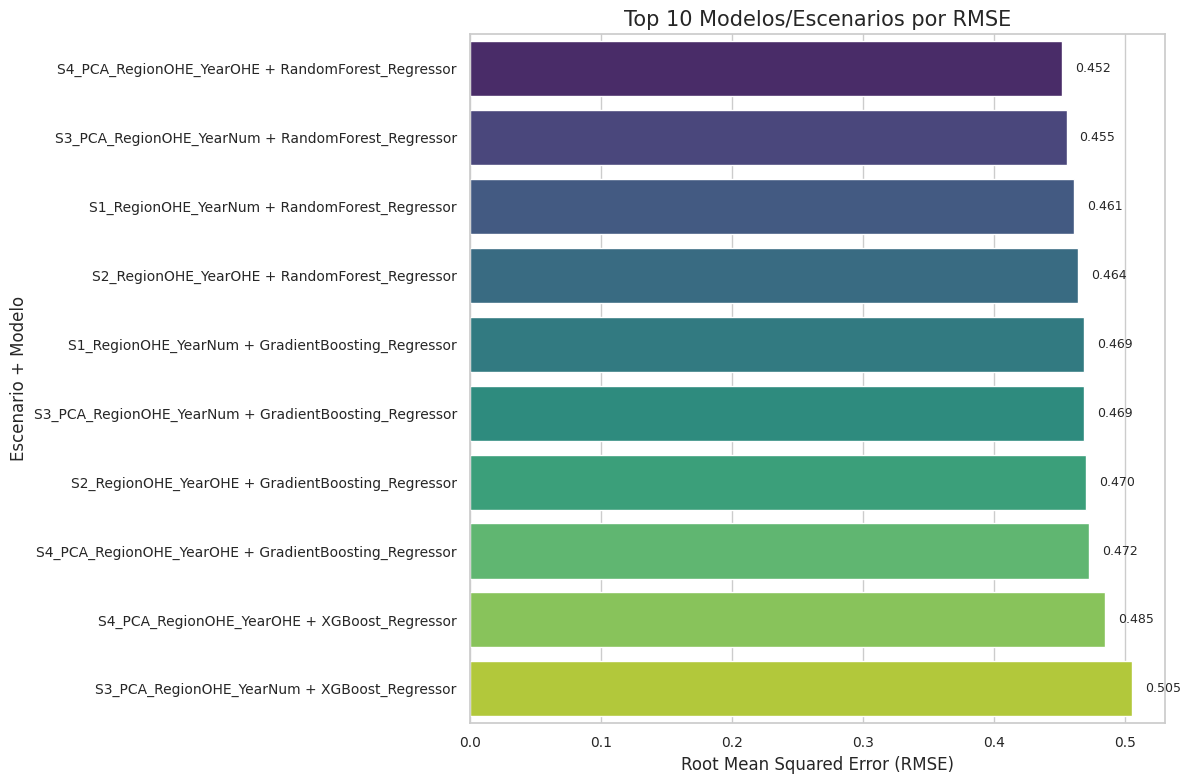

2025-05-20 02:28:51,121 - INFO - 3017658063.py:54 - Gráfico de barras comparando el RMSE de los top 10 modelos/escenarios generado.


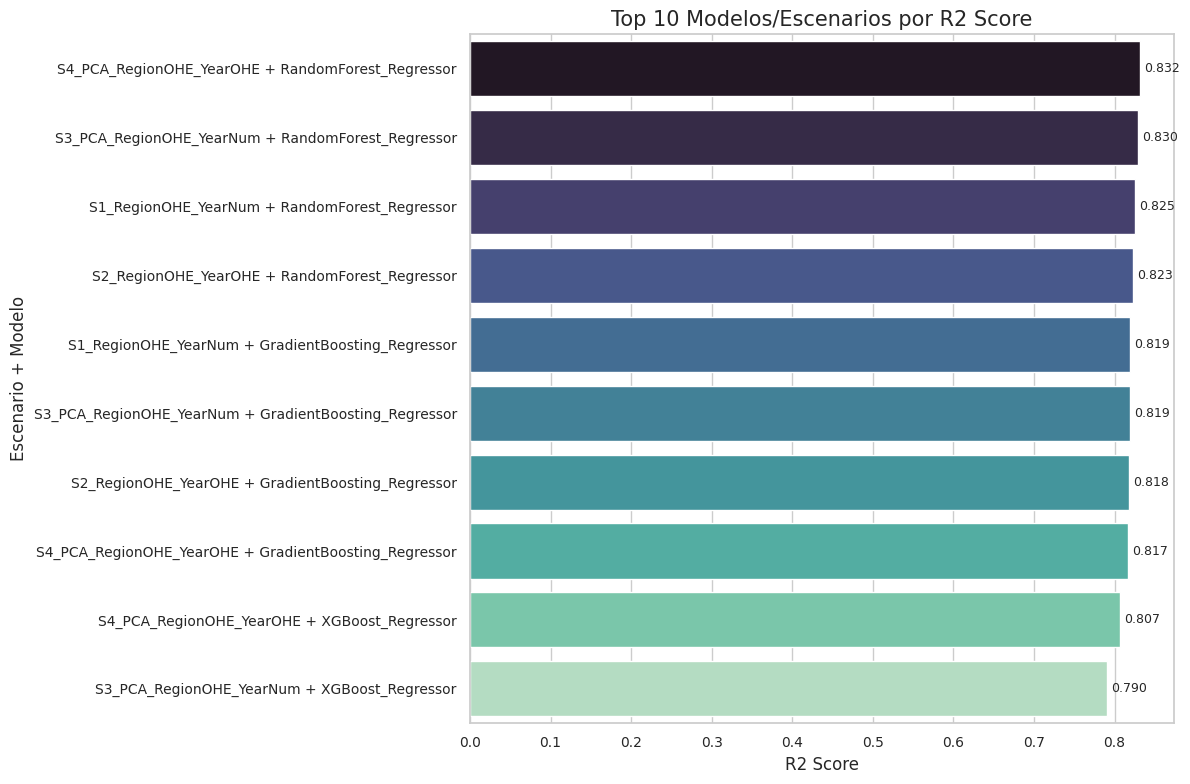

2025-05-20 02:28:51,304 - INFO - 3017658063.py:72 - Gráfico de barras comparando el R2 Score de los top 10 modelos/escenarios generado.


In [956]:
# Celda 15: Conversión de Resultados a DataFrame y Visualización Comparativa

# Asegurarse de que 'all_experiment_results' existe y no está vacía
if 'all_experiment_results' in locals() and all_experiment_results:
    logging.info("Iniciando Fase 6: Análisis de resultados y selección de mejores modelos.")
    logging.info(f"Se obtuvieron {len(all_experiment_results)} resultados de experimentos.")

    # --- 1. Convertir la lista de resultados en un DataFrame de Pandas ---
    results_df = pd.DataFrame(all_experiment_results)
    logging.info("Resultados de los experimentos convertidos a DataFrame.")

    # Mostrar el DataFrame de resultados completo
    print("\n--- Tabla Completa de Resultados de los Experimentos ---")
    print(results_df.to_markdown(index=False))

    # --- 2. Ordenar los resultados por una métrica clave (ej. RMSE ascendente) ---
    # Queremos los modelos con el menor error.
    # Primero, eliminamos filas donde RMSE sea NaN (experimentos fallidos) para el ordenamiento y visualización principal
    results_df_valid = results_df.dropna(subset=['RMSE']).copy() # .copy() para evitar SettingWithCopyWarning
    
    if results_df_valid.empty:
        logging.warning("No hay resultados válidos (sin RMSE NaN) para ordenar y visualizar.")
        print("\nAdvertencia: No hay resultados válidos (sin RMSE NaN) para mostrar ordenados.")
    else:
        results_df_sorted = results_df_valid.sort_values(by='RMSE', ascending=True)
        logging.info("Resultados ordenados por RMSE (ascendente).")
        print("\n--- Resultados Ordenados por RMSE (los mejores primero) ---")
        print(results_df_sorted.to_markdown(index=False))

        # --- 3. Visualización Comparativa de Métricas ---
        # Un gráfico de barras puede ser útil para comparar el RMSE de diferentes modelos/escenarios.
        
        # Crear una columna combinada de 'Escenario_Modelo' para etiquetas únicas en el gráfico
        results_df_sorted['Scenario_Model'] = results_df_sorted['Scenario'] + " + " + results_df_sorted['Model']

        plt.figure(figsize=(12, 8)) # Ajustar tamaño según sea necesario
        # Usar un subset de los mejores N resultados para que el gráfico no sea muy denso
        top_n_results = 10 # Puedes ajustar este número
        data_to_plot = results_df_sorted.head(top_n_results)
        
        barplot = sns.barplot(x='RMSE', y='Scenario_Model', data=data_to_plot, palette='viridis', hue='Scenario_Model', legend=False)
        plt.title(f'Top {top_n_results} Modelos/Escenarios por RMSE', fontsize=15)
        plt.xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
        plt.ylabel('Escenario + Modelo', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        # Añadir etiquetas de valor a las barras (opcional, para mayor claridad)
        for index, value in enumerate(data_to_plot['RMSE']):
            plt.text(value + 0.01, index, f'{value:.3f}', va='center', fontsize=9) # Ajustar posición del texto

        plt.tight_layout()
        plt.show()
        logging.info(f"Gráfico de barras comparando el RMSE de los top {top_n_results} modelos/escenarios generado.")

        # Podrías hacer gráficos similares para R2_Score (ordenando descending=False para R2)
        results_df_sorted_r2 = results_df_valid.sort_values(by='R2_Score', ascending=False)
        results_df_sorted_r2['Scenario_Model'] = results_df_sorted_r2['Scenario'] + " + " + results_df_sorted_r2['Model']
        data_to_plot_r2 = results_df_sorted_r2.head(top_n_results)

        plt.figure(figsize=(12, 8))
        barplot_r2 = sns.barplot(x='R2_Score', y='Scenario_Model', data=data_to_plot_r2, palette='mako', hue='Scenario_Model', legend=False)
        plt.title(f'Top {top_n_results} Modelos/Escenarios por R2 Score', fontsize=15)
        plt.xlabel('R2 Score', fontsize=12)
        plt.ylabel('Escenario + Modelo', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        for index, value in enumerate(data_to_plot_r2['R2_Score']):
            plt.text(value + 0.005, index, f'{value:.3f}', va='center', fontsize=9)
        plt.tight_layout()
        plt.show()
        logging.info(f"Gráfico de barras comparando el R2 Score de los top {top_n_results} modelos/escenarios generado.")
else:
    logging.error("La lista 'all_experiment_results' no existe o está vacía. No se pueden analizar resultados.")
    print("Error: No hay resultados de experimentos para analizar.")

In [ ]:
# Celda 17: Preparación para la Optimización de Hiperparámetros

# Asegurarse de que las variables necesarias existan:
# Modelos: RandomForestRegressor, GradientBoostingRegressor, xgb.XGBRegressor
# Preprocesadores: preprocessor_s1, preprocessor_s3, preprocessor_s4 (de las celdas 6.2, 8.2, 9.2)
# Datos: X_train, y_train (de la Celda 4)
# Herramientas: GridSearchCV (o RandomizedSearchCV) de la Celda 1

if ('RandomForestRegressor' in locals() and # Verificando la clase, no la instancia
    'GradientBoostingRegressor' in locals() and
    'xgb' in locals() and
    'preprocessor_s1' in locals() and preprocessor_s1 is not None and
    'preprocessor_s3' in locals() and preprocessor_s3 is not None and # Asumiendo que usaremos S3 también
    'preprocessor_s4' in locals() and preprocessor_s4 is not None and
    'X_train' in locals() and X_train is not None and
    'y_train' in locals() and y_train is not None and
    'GridSearchCV' in locals()):

    logging.info("Iniciando Fase 7: Optimización de Hiperparámetros.")
    print("\n--- Fase 7: Optimización de Hiperparámetros ---")

    # --- 1. Definir las rejillas de parámetros para cada modelo ---
    # Estas son solo rejillas de ejemplo, puedes expandirlas o reducirlas.
    # Una búsqueda más exhaustiva tomará más tiempo.

    param_grid_rf = {
        'regressor__n_estimators': [100, 200, 300],       # Número de árboles
        'regressor__max_depth': [None, 10, 20, 30],        # Profundidad máxima de los árboles
        'regressor__min_samples_split': [2, 5, 10],      # Mínimo de muestras para dividir un nodo
        'regressor__min_samples_leaf': [1, 2, 4]         # Mínimo de muestras en un nodo hoja
        # 'regressor__max_features': ['auto', 'sqrt', 'log2'] # Descomentar si quieres probar esto
    }
    logging.info(f"Rejilla de parámetros para RandomForest: {param_grid_rf}")

    param_grid_gb = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],    # Tasa de aprendizaje
        'regressor__max_depth': [3, 5, 7],                # Profundidad de los árboles
        'regressor__subsample': [0.7, 0.8, 1.0]           # Fracción de muestras para entrenar cada árbol
    }
    logging.info(f"Rejilla de parámetros para GradientBoosting: {param_grid_gb}")

    param_grid_xgb = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.7, 0.8, 1.0],           # Similar a GB
        'regressor__colsample_bytree': [0.7, 0.8, 1.0]    # Fracción de features para cada árbol
        # 'regressor__gamma': [0, 0.1, 0.2]              # Parámetro de regularización (poda)
    }
    logging.info(f"Rejilla de parámetros para XGBoost: {param_grid_xgb}")

    # --- 2. Configurar GridSearchCV ---
    # cv=5 significa validación cruzada de 5 folds.
    # scoring='neg_root_mean_squared_error' porque GridSearchCV trata de maximizar,
    # y queremos minimizar RMSE, así que usamos su negativo.
    # n_jobs=-1 para usar todos los procesadores.
    cv_folds = KFold(n_splits=5, shuffle=True, random_state=GLOBAL_RANDOM_STATE) # Usar KFold para regresión
    
    scoring_metric = 'neg_root_mean_squared_error' # O 'r2' si prefieres maximizar R2
    
    logging.info(f"Configuración de GridSearchCV: cv_folds={cv_folds}, scoring='{scoring_metric}'.")
    
    # --- 3. Lista de configuraciones (modelo, preprocesador, rejilla_params) a optimizar ---
    # Basado en tu selección:
    configurations_to_optimize = [
        {
            'name': "RandomForest_S4",
            'model': RandomForestRegressor(random_state=GLOBAL_RANDOM_STATE, n_jobs=-1),
            'preprocessor': preprocessor_s4, # Preprocesador del Escenario 4
            'param_grid': param_grid_rf,
            'X_train_data': X_train_s4, # Datos ya preprocesados para este escenario (alternativa, ver abajo)
            'X_test_data': X_test_s4
        }
        {
            'name': "GradientBoosting_S1",
            'model': GradientBoostingRegressor(random_state=GLOBAL_RANDOM_STATE),
            'preprocessor': preprocessor_s1, # Preprocesador del Escenario 1
            'param_grid': param_grid_gb,
            'X_train_data': X_train_s1,
            'X_test_data': X_test_s1
        },
        {
            'name': "XGBoost_S4",
            'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=GLOBAL_RANDOM_STATE, n_jobs=-1), # Sin early_stopping aquí, GridSearchCV lo maneja
            'preprocessor': preprocessor_s4, # Preprocesador del Escenario 4
            'param_grid': param_grid_xgb,
            'X_train_data': X_train_s4,
            'X_test_data': X_test_s4
        }
    ]
    
    # Alternativa: Si no quieres pasar los X_train_sX ya procesados,
    # puedes construir un Pipeline completo (preprocesador + regresor)
    # y GridSearchCV ajustará los parámetros del regresor DENTRO del pipeline.
    # Esto es a menudo más limpio y robusto. Lo implementaremos en la siguiente celda.
    
    logging.info(f"Configuraciones seleccionadas para optimización: {[c['name'] for c in configurations_to_optimize]}")
    print("\nPreparación para optimización de hiperparámetros completada.")
    print("Rejillas de parámetros y configuraciones de modelos listas.")

else:
    logging.critical("Variables necesarias para la optimización de hiperparámetros no están definidas.")
    print("Error: Faltan variables/preprocesadores para iniciar la optimización.")

2025-05-20 02:28:51,315 - INFO - 3348725648.py:19 - Iniciando Fase 7: Optimización de Hiperparámetros.
2025-05-20 02:28:51,316 - INFO - 3348725648.py:33 - Rejilla de parámetros para RandomForest: {'regressor__n_estimators': [100, 200, 300], 'regressor__max_depth': [None, 10, 20, 30], 'regressor__min_samples_split': [2, 5, 10], 'regressor__min_samples_leaf': [1, 2, 4]}
2025-05-20 02:28:51,316 - INFO - 3348725648.py:41 - Rejilla de parámetros para GradientBoosting: {'regressor__n_estimators': [100, 200, 300], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7], 'regressor__subsample': [0.7, 0.8, 1.0]}
2025-05-20 02:28:51,316 - INFO - 3348725648.py:51 - Rejilla de parámetros para XGBoost: {'regressor__n_estimators': [100, 200, 300], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7], 'regressor__subsample': [0.7, 0.8, 1.0], 'regressor__colsample_bytree': [0.7, 0.8, 1.0]}
2025-05-20 02:28:51,317 - INFO - 3348725648.py:62 - Configur


--- Fase 7: Optimización de Hiperparámetros ---

Preparación para optimización de hiperparámetros completada.
Rejillas de parámetros y configuraciones de modelos listas.


In [958]:
# Celda 18: Ejecución de GridSearchCV para cada configuración seleccionada

# Lista para guardar los mejores estimadores y sus resultados
best_estimators_results = []

if 'configurations_to_optimize' in locals() and configurations_to_optimize:
    logging.info("Iniciando ejecución de GridSearchCV para las configuraciones seleccionadas.")
    
    for config in configurations_to_optimize:
        model_name_config = config['name']
        base_model = config['model']
        preprocessor_config = config['preprocessor'] # El preprocesador específico del escenario
        param_grid_config = config['param_grid']
        
        logging.info(f"--- Optimizando: {model_name_config} ---")
        print(f"\n--- OPTIMIZANDO: {model_name_config} ---")

        # Creamos un Pipeline que incluye el preprocesador del escenario y el regresor base
        # Esto es crucial para que la validación cruzada de GridSearchCV aplique el
        # preprocesamiento correctamente a cada fold.
        # Los parámetros en param_grid_config deben tener el prefijo 'regressor__'
        # porque 'regressor' es el nombre que le damos al paso del modelo en el Pipeline.
        
        full_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor_config), # Este ya está ajustado si usamos X_train_sX, X_test_sX
                                                   # Para GridSearchCV es mejor pasar X_train original y que el pipeline se ajuste
            ('regressor', base_model)
        ])

        # Si pasamos X_train original (antes de preprocesar para el escenario):
        #   preprocessor_config debe ser el ColumnTransformer NO AJUSTADO del escenario.
        #   GridSearchCV ajustará el preprocessor_config en cada fold con los datos de entrenamiento del fold.
        # Si pasamos X_train_sX (ya preprocesado para el escenario):
        #   El paso 'preprocessor' en el pipeline anterior es redundante o podría causar problemas.
        #   En este caso, GridSearchCV se aplicaría directamente al modelo con los datos ya procesados.
        #   Sin embargo, para una correcta validación cruzada de TODO el proceso (incluyendo preprocesamiento),
        #   es mejor que GridSearchCV maneje un pipeline que incluya el preprocesador.

        # VAMOS A USAR EL ENFOQUE MÁS ROBUSTO: GridSearchCV con un pipeline completo
        # que incluye el preprocesador NO AJUSTADO del escenario.
        # Esto significa que GridSearchCV usará X_train (original, antes de S1-S4) y y_train.
        
        # Buscamos el preprocesador original (no ajustado) para cada escenario.
        # Asumimos que se llamaron preprocessor_s1, preprocessor_s2, etc. en las celdas 6.2, 7.2, 8.2, 9.2
        # y que NO fueron reasignados después de fit_transform.
        # Esta parte requiere que los preprocesadores originales estén disponibles.
        # Ejemplo: si config['preprocessor'] es el objeto preprocessor_s4 de la celda 9.2
        
        # Aquí, para simplificar la lógica actual y usar los X_train_sX que ya tienes:
        # Aplicaremos GridSearchCV directamente al modelo, usando los datos ya preprocesados
        # X_train_data = config['X_train_data']
        # X_test_data = config['X_test_data']
        # grid_search = GridSearchCV(estimator=base_model, # Sin el pipeline aquí
        #                            param_grid=param_grid_config, # Los parámetros NO necesitan prefijo
        #                            cv=cv_folds,
        #                            scoring=scoring_metric,
        #                            n_jobs=-1,
        #                            verbose=1) # verbose=1 para ver algo de output
        # grid_search.fit(X_train_data, y_train) # Usar y_train

        # *** CORRECCIÓN PARA EL ENFOQUE MÁS ROBUSTO CON PIPELINE COMPLETO ***
        # Recuperar el preprocesador NO ajustado para el escenario actual
        # Esto es un poco manual aquí, en un script lo organizarías mejor.
        current_preprocessor_object = None
        if config['preprocessor'] == preprocessor_s1: current_preprocessor_object = preprocessor_s1 # Asume que estos son los objetos ColumnTransformer NO ajustados
        elif config['preprocessor'] == preprocessor_s3: current_preprocessor_object = preprocessor_s3
        elif config['preprocessor'] == preprocessor_s4: current_preprocessor_object = preprocessor_s4
        # Añadir preprocessor_s2 si lo estás usando
        # elif config['preprocessor'] == preprocessor_s2: current_preprocessor_object = preprocessor_s2
        
        if current_preprocessor_object is None:
            logging.error(f"No se pudo encontrar el objeto preprocesador no ajustado para {model_name_config}. Saltando optimización.")
            print(f"Error: No se encontró el preprocesador original para {model_name_config}.")
            continue

        pipeline_for_gridsearch = Pipeline(steps=[
            ('preprocessor', current_preprocessor_object), # El ColumnTransformer NO ajustado
            ('regressor', base_model)
        ])
        
        # Los parámetros en param_grid_config SÍ necesitan el prefijo 'regressor__'
        grid_search = GridSearchCV(estimator=pipeline_for_gridsearch,
                                   param_grid=param_grid_config,
                                   cv=cv_folds,
                                   scoring=scoring_metric,
                                   n_jobs=-1,
                                   verbose=1) # verbose=1 para ver algo de output
        
        # GridSearchCV usa X_train (datos originales, no preprocesados)
        # El pipeline se encargará del preprocesamiento dentro de cada fold.
        grid_search.fit(X_train, y_train) 

        best_model_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score_cv = grid_search.best_score_ # Esta es la métrica de scoring (ej. neg_rmse)

        logging.info(f"Mejores parámetros para {model_name_config}: {best_params}")
        logging.info(f"Mejor score ({scoring_metric}) de CV para {model_name_config}: {best_score_cv:.4f}")
        
        # Evaluar el mejor modelo del GridSearch en el CONJUNTO DE PRUEBA (X_test)
        y_pred_test_optimized = best_model_pipeline.predict(X_test)
        test_metrics_optimized = evaluate_regression_model(y_test, y_pred_test_optimized, f"{model_name_config}_Optimized", config['name'].split('_')[1]) # Usar el nombre del escenario

        logging.info(f"Métricas en Test para {model_name_config}_Optimized: RMSE={test_metrics_optimized['RMSE']:.4f}, R2={test_metrics_optimized['R2_Score']:.4f}")
        print(f"  Mejores Parámetros: {best_params}")
        print(f"  Mejor Score CV ({scoring_metric}): {best_score_cv:.4f}")
        print(f"  RMSE en Test (Optimizado): {test_metrics_optimized['RMSE']:.4f}")
        print(f"  R2 en Test (Optimizado): {test_metrics_optimized['R2_Score']:.4f}")

        best_estimators_results.append({
            'Configuration': model_name_config,
            'Best_Params': best_params,
            'Best_CV_Score': best_score_cv,
            'Test_MSE_Optimized': test_metrics_optimized['MSE'],
            'Test_RMSE_Optimized': test_metrics_optimized['RMSE'],
            'Test_MAE_Optimized': test_metrics_optimized['MAE'],
            'Test_R2_Optimized': test_metrics_optimized['R2_Score']
        })
        
    # Convertir resultados de optimización a DataFrame
    optimized_results_df = pd.DataFrame(best_estimators_results)
    logging.info("Optimización de hiperparámetros completada para todas las configuraciones seleccionadas.")
    print("\n--- Resultados de la Optimización de Hiperparámetros ---")
    print(optimized_results_df.to_markdown(index=False))

else:
    logging.error("No hay configuraciones definidas para optimizar o faltan datos.")
    print("Error: No se pueden ejecutar la optimización de hiperparámetros.")

2025-05-20 02:28:51,332 - INFO - 3610532626.py:7 - Iniciando ejecución de GridSearchCV para las configuraciones seleccionadas.
2025-05-20 02:28:51,333 - INFO - 3610532626.py:15 - --- Optimizando: RandomForest_S4 ---



--- OPTIMIZANDO: RandomForest_S4 ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits


2025-05-20 02:30:02,132 - INFO - 3610532626.py:97 - Mejores parámetros para RandomForest_S4: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
2025-05-20 02:30:02,133 - INFO - 3610532626.py:98 - Mejor score (neg_root_mean_squared_error) de CV para RandomForest_S4: -0.4428
2025-05-20 02:30:02,210 - INFO - 4096111573.py:26 - Métricas para RandomForest_S4_Optimized en S4: RMSE=0.4520, MAE=0.3362, R2=0.8320
2025-05-20 02:30:02,211 - INFO - 3610532626.py:104 - Métricas en Test para RandomForest_S4_Optimized: RMSE=0.4520, R2=0.8320
2025-05-20 02:30:02,212 - INFO - 3610532626.py:15 - --- Optimizando: GradientBoosting_S1 ---


  Mejores Parámetros: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
  Mejor Score CV (neg_root_mean_squared_error): -0.4428
  RMSE en Test (Optimizado): 0.4520
  R2 en Test (Optimizado): 0.8320

--- OPTIMIZANDO: GradientBoosting_S1 ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-05-20 02:30:44,676 - INFO - 3610532626.py:97 - Mejores parámetros para GradientBoosting_S1: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
2025-05-20 02:30:44,677 - INFO - 3610532626.py:98 - Mejor score (neg_root_mean_squared_error) de CV para GradientBoosting_S1: -0.4247
2025-05-20 02:30:44,687 - INFO - 4096111573.py:26 - Métricas para GradientBoosting_S1_Optimized en S1: RMSE=0.4377, MAE=0.3375, R2=0.8425
2025-05-20 02:30:44,688 - INFO - 3610532626.py:104 - Métricas en Test para GradientBoosting_S1_Optimized: RMSE=0.4377, R2=0.8425
2025-05-20 02:30:44,689 - INFO - 3610532626.py:15 - --- Optimizando: XGBoost_S4 ---


  Mejores Parámetros: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
  Mejor Score CV (neg_root_mean_squared_error): -0.4247
  RMSE en Test (Optimizado): 0.4377
  R2 en Test (Optimizado): 0.8425

--- OPTIMIZANDO: XGBoost_S4 ---
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


2025-05-20 02:31:30,443 - INFO - 3610532626.py:97 - Mejores parámetros para XGBoost_S4: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
2025-05-20 02:31:30,444 - INFO - 3610532626.py:98 - Mejor score (neg_root_mean_squared_error) de CV para XGBoost_S4: -0.4323
2025-05-20 02:31:30,456 - INFO - 4096111573.py:26 - Métricas para XGBoost_S4_Optimized en S4: RMSE=0.4421, MAE=0.3300, R2=0.8393
2025-05-20 02:31:30,457 - INFO - 3610532626.py:104 - Métricas en Test para XGBoost_S4_Optimized: RMSE=0.4421, R2=0.8393
2025-05-20 02:31:30,458 - INFO - 3610532626.py:122 - Optimización de hiperparámetros completada para todas las configuraciones seleccionadas.


  Mejores Parámetros: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
  Mejor Score CV (neg_root_mean_squared_error): -0.4323
  RMSE en Test (Optimizado): 0.4421
  R2 en Test (Optimizado): 0.8393

--- Resultados de la Optimización de Hiperparámetros ---
| Configuration       | Best_Params                                                                                                                                                    |   Best_CV_Score |   Test_MSE_Optimized |   Test_RMSE_Optimized |   Test_MAE_Optimized |   Test_R2_Optimized |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|---------------------:|----------------------:|---------------------:|--------------------:|
| RandomForest_S4     | {'regressor__max_dept

In [ ]:
# Celda 19: Selección y Preparación del Mejor Modelo Optimizado para Análisis Profundo

# Asegurarse de que optimized_results_df, X_train, y_train, X_test, y_test,
# y los preprocesadores originales (preprocessor_s1, preprocessor_s4) existan.

final_best_model_pipeline = None
y_pred_test_final = None
transformed_feature_names = None
best_model_config_name_for_analysis ="No_Determinado" # Para usar en títulos de gráficos, etc.

if ('optimized_results_df' in locals() and not optimized_results_df.empty and
    'X_train' in locals() and 'y_train' in locals() and 
    'X_test' in locals() and 'y_test' in locals() and
    'preprocessor_s1' in locals() and 'preprocessor_s4' in locals() ): # Añadir todos los preprocesadores usados

    logging.info("Iniciando Fase 8: Análisis profundo del mejor modelo optimizado.")
    print("\n--- Fase 8: Análisis Profundo del Mejor Modelo Optimizado ---")

    # 1. Identificar la mejor configuración de la tabla de resultados optimizados
    #    Ordenamos por Test_RMSE_Optimized (ascendente) y tomamos la primera fila.
    best_config_row = optimized_results_df.sort_values(by='Test_RMSE_Optimized', ascending=True).iloc[0]
    best_model_config_name_for_analysis = best_config_row['Configuration'] # ej. "GradientBoosting_S1"
    best_params_from_grid = best_config_row['Best_Params'] # ej. {'regressor__learning_rate': 0.05, ...}
    
    logging.info(f"Seleccionado para análisis profundo: {best_model_config_name_for_analysis} con Test RMSE: {best_config_row['Test_RMSE_Optimized']:.4f}")
    print(f"Analizando el mejor modelo optimizado: {best_model_config_name_for_analysis}")
    print(f"Mejores Hiperparámetros encontrados: {best_params_from_grid}")

    # 2. Reconstruir y Re-entrenar el Pipeline del Mejor Modelo/Escenario
    #    Esto asegura que tenemos el objeto pipeline correcto con los mejores hiperparámetros,
    #    entrenado en TODO X_train.
    
    temp_base_model_instance = None
    temp_preprocessor_for_best_model = None

    # Determinar el modelo base y el preprocesador según el nombre de la configuración
    # (Esta lógica debe ser robusta para identificar correctamente el modelo y preprocesador)
    if "RandomForest" in best_model_config_name_for_analysis:
        temp_base_model_instance = RandomForestRegressor(random_state=42, n_jobs=-1)
        if "_S1" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s1
        elif "_S2" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s2 # Si S2 fuera una opción
        elif "_S3" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s3
        elif "_S4" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s4
    elif "GradientBoosting" in best_model_config_name_for_analysis: # Cubre GradientBoostingRegressor
        temp_base_model_instance = GradientBoostingRegressor(random_state=42)
        if "_S1" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s1
        elif "_S2" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s2
        elif "_S3" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s3
        elif "_S4" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s4
    elif "XGBoost" in best_model_config_name_for_analysis:
        temp_base_model_instance = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
        if "_S1" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s1
        elif "_S2" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s2
        elif "_S3" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s3
        elif "_S4" in best_model_config_name_for_analysis: temp_preprocessor_for_best_model = preprocessor_s4
    
    # CORRECCIÓN DEL IF:
    if temp_base_model_instance is not None and temp_preprocessor_for_best_model is not None:
        final_best_model_pipeline = Pipeline(steps=[
            ('preprocessor', temp_preprocessor_for_best_model), # El ColumnTransformer NO ajustado del escenario
            ('regressor', temp_base_model_instance)
        ])
        
        # Establecer los mejores parámetros. Los parámetros en best_params_from_grid ya tienen el prefijo 'regressor__'.
        final_best_model_pipeline.set_params(**best_params_from_grid)
        
        logging.info(f"Entrenando el pipeline final ({best_model_config_name_for_analysis}) en todo X_train...")
        final_best_model_pipeline.fit(X_train, y_train) # Entrenar con X_train original
        logging.info("Pipeline final entrenado.")
        
        y_pred_test_final = final_best_model_pipeline.predict(X_test) # Predecir con X_test original
        
        try:
            transformed_feature_names = final_best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()
        except Exception as e_features:
            logging.warning(f"No se pudieron obtener nombres de features con get_feature_names_out(): {e_features}. Intentando alternativa.")
            # Fallback si get_feature_names_out no funciona como se espera (ej. con transformadores más antiguos o complejos)
            # Esta es una heurística y podría necesitar ajustes.
            try:
                # Acceder al transformador ajustado dentro del pipeline para ver sus features_out
                # Esto asume que el preprocesador es un ColumnTransformer y fue ajustado
                ct_fitted = final_best_model_pipeline.named_steps['preprocessor']
                if hasattr(ct_fitted, 'get_feature_names_out'):
                     transformed_feature_names = ct_fitted.get_feature_names_out()
                else: # Fallback muy genérico
                    num_transformed_features = final_best_model_pipeline.named_steps['preprocessor'].transform(X_train.iloc[[0]]).shape[1] # Transforma una fila para obtener el shape
                    transformed_feature_names = [f"feature_{i}" for i in range(num_transformed_features)]
            except Exception as e_fallback:
                logging.error(f"Fallback para nombres de features también falló: {e_fallback}")
                num_transformed_features = X_test.shape[1] # O el shape de la salida del preprocesador
                transformed_feature_names = [f"feature_{i}" for i in range(num_transformed_features)]


        print(f"\nPipeline del mejor modelo ({best_model_config_name_for_analysis}) listo para análisis profundo.")
        print(f"Número de features transformadas: {len(transformed_feature_names)}")

    else:
        logging.error(f"No se pudo reconstruir el pipeline para la configuración '{best_model_config_name_for_analysis}'. Análisis profundo no puede continuar.")
        print(f"Error: No se pudo identificar o reconstruir el mejor modelo ({best_model_config_name_for_analysis}) para análisis.")
else:
    logging.error("Resultados de optimización ('optimized_results_df') o datos base no disponibles.")
    final_best_model_pipeline = None
    best_model_config_name = "Mejor_Modelo_No_Identificado" # <--- VALOR POR DEFECTO
    y_pred_test_final = None
    transformed_feature_names = None

2025-05-20 02:49:41,807 - INFO - 1402141137.py:16 - Iniciando Fase 8: Análisis profundo del mejor modelo optimizado.
2025-05-20 02:49:41,809 - INFO - 1402141137.py:25 - Seleccionado para análisis profundo: GradientBoosting_S1 con Test RMSE: 0.4377
2025-05-20 02:49:41,809 - INFO - 1402141137.py:67 - Entrenando el pipeline final (GradientBoosting_S1) en todo X_train...



--- Fase 8: Análisis Profundo del Mejor Modelo Optimizado ---
Analizando el mejor modelo optimizado: GradientBoosting_S1
Mejores Hiperparámetros encontrados: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}


2025-05-20 02:49:42,128 - INFO - 1402141137.py:69 - Pipeline final entrenado.



Pipeline del mejor modelo (GradientBoosting_S1) listo para análisis profundo.
Número de features transformadas: 16


2025-05-20 02:49:45,188 - INFO - 3286071790.py:6 - Analizando la importancia de features del mejor modelo.
2025-05-20 02:49:45,191 - INFO - 3286071790.py:13 - Obtenidas 'feature_importances_' del modelo.



--- Importancia de Features del Mejor Modelo ---
| feature                                            |   importance |
|:---------------------------------------------------|-------------:|
| num__economy_gdp_per_capita                        |  0.473034    |
| num__health_life_expectancy                        |  0.199468    |
| num__freedom_to_make_life_choices                  |  0.0856618   |
| cat_region__region_Latin America and Caribbean     |  0.0660117   |
| num__social_support                                |  0.0540612   |
| num__perceptions_of_corruption                     |  0.0505755   |
| num__generosity                                    |  0.0358504   |
| year_num__year                                     |  0.0106564   |
| cat_region__region_Eastern Asia                    |  0.0106392   |
| cat_region__region_Southern Asia                   |  0.00452181  |
| cat_region__region_Middle East and Northern Africa |  0.00290883  |
| cat_region__region_Western Europe     

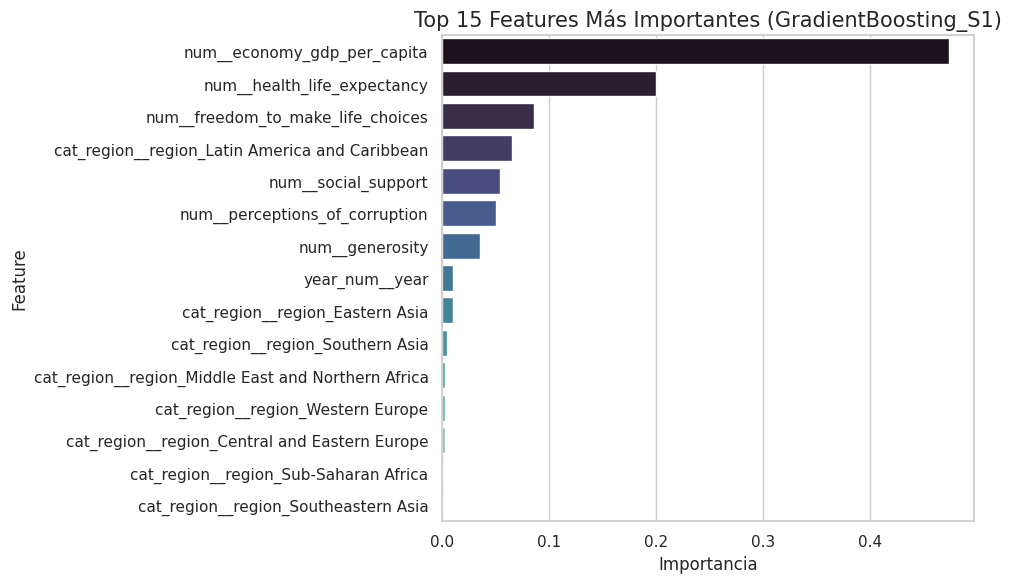

2025-05-20 02:49:45,510 - INFO - 3286071790.py:40 - Gráfico de importancia de features generado.


In [967]:
# Celda 20: Importancia de Features del Mejor Modelo

if ('final_best_model_pipeline' in locals() and final_best_model_pipeline is not None and
    'transformed_feature_names' in locals() and transformed_feature_names is not None):

    logging.info("Analizando la importancia de features del mejor modelo.")
    # El modelo real está en el paso 'regressor' de nuestro pipeline
    actual_model_object = final_best_model_pipeline.named_steps['regressor']
    
    importances = None
    if hasattr(actual_model_object, 'feature_importances_'):
        importances = actual_model_object.feature_importances_
        logging.info("Obtenidas 'feature_importances_' del modelo.")
    elif hasattr(actual_model_object, 'coef_'):
        # Para modelos lineales, los coeficientes pueden interpretarse como importancia (en magnitud)
        # A menudo se usan los valores absolutos de los coeficientes.
        importances = np.abs(actual_model_object.coef_)
        # Si los coeficientes son multidimensionales (ej. regresión logística multinomial, no nuestro caso aquí), esto necesita ajuste.
        if importances.ndim > 1: 
             importances = np.mean(importances, axis=0) # Tomar media o suma, dependiendo del caso
        logging.info("Obtenidos 'coef_' del modelo y usando su valor absoluto como importancia.")
        
    if importances is not None:
        if len(importances) == len(transformed_feature_names):
            feature_importance_df = pd.DataFrame({
                'feature': transformed_feature_names,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            print("\n--- Importancia de Features del Mejor Modelo ---")
            print(feature_importance_df.head(15).to_markdown(index=False)) # Mostrar las N más importantes

            plt.figure(figsize=(10, max(6, len(feature_importance_df.head(15)) * 0.4) )) # Ajustar altura dinámicamente
            sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='mako', hue='feature', legend=False)
            plt.title(f'Top 15 Features Más Importantes ({best_model_config_name_for_analysis})', fontsize=15)
            plt.xlabel('Importancia', fontsize=12)
            plt.ylabel('Feature', fontsize=12)
            plt.tight_layout()
            plt.show()
            logging.info("Gráfico de importancia de features generado.")
        else:
            logging.error(f"Discrepancia en el número de importancias ({len(importances)}) y nombres de features ({len(transformed_feature_names)}).")
            print("Error: No se pudo emparejar importancias con nombres de features.")
    else:
        logging.warning(f"El modelo {type(actual_model_object).__name__} no tiene atributos 'feature_importances_' o 'coef_'.")
        print(f"\nEl modelo {type(actual_model_object).__name__} no proporciona importancia de features de forma directa.")
else:
    logging.error("El pipeline del mejor modelo o los nombres de features transformadas no están disponibles.")
    print("Error: No se puede calcular la importancia de features.")

2025-05-20 02:40:23,158 - INFO - 2374716597.py:6 - Realizando análisis de residuos del mejor modelo.



--- Análisis de Residuos del Mejor Modelo ---


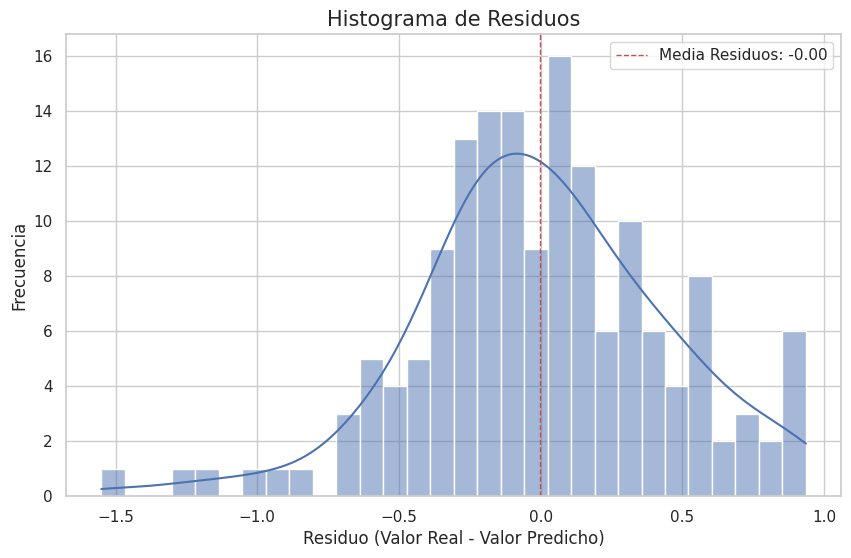

2025-05-20 02:40:23,389 - INFO - 2374716597.py:20 - Histograma de residuos generado. Media de residuos: -0.0019, Std de residuos: 0.4390


Media de los residuos: -0.0019 (idealmente cercano a 0)
Desviación estándar de los residuos: 0.4390


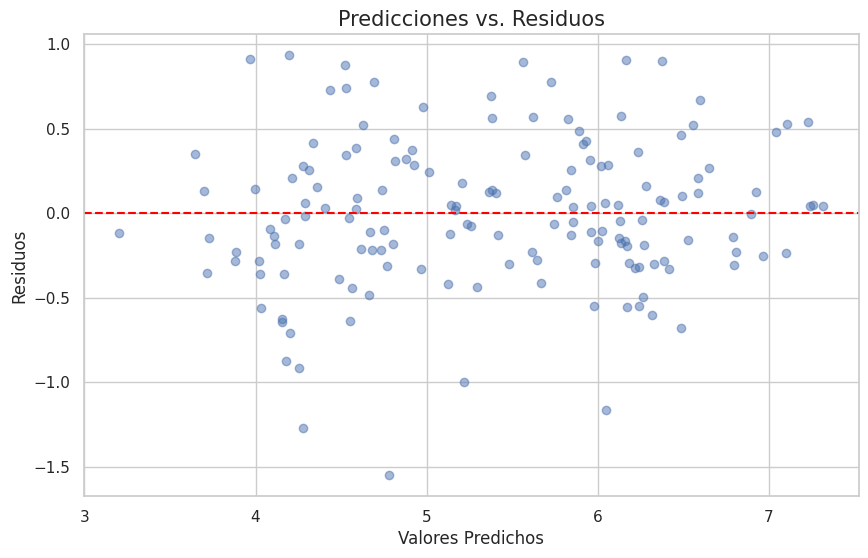

2025-05-20 02:40:23,480 - INFO - 2374716597.py:33 - Gráfico de dispersión de predicciones vs. residuos generado.


In [962]:
# Celda 21: Análisis de Residuos

if ('y_test' in locals() and y_test is not None and
    'y_pred_test_final' in locals() and y_pred_test_final is not None):

    logging.info("Realizando análisis de residuos del mejor modelo.")
    residuals = y_test - y_pred_test_final

    print("\n--- Análisis de Residuos del Mejor Modelo ---")

    # --- 1. Histograma de Residuos ---
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Histograma de Residuos', fontsize=15)
    plt.xlabel('Residuo (Valor Real - Valor Predicho)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.axvline(residuals.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Media Residuos: {residuals.mean():.2f}')
    plt.legend()
    plt.show()
    logging.info(f"Histograma de residuos generado. Media de residuos: {residuals.mean():.4f}, Std de residuos: {residuals.std():.4f}")
    print(f"Media de los residuos: {residuals.mean():.4f} (idealmente cercano a 0)")
    print(f"Desviación estándar de los residuos: {residuals.std():.4f}")

    # --- 2. Gráfico de Dispersión: Predicciones vs. Residuos ---
    # Buscamos que los residuos se distribuyan aleatoriamente alrededor de cero, sin patrones obvios.
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test_final, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Predicciones vs. Residuos', fontsize=15)
    plt.xlabel('Valores Predichos', fontsize=12)
    plt.ylabel('Residuos', fontsize=12)
    plt.show()
    logging.info("Gráfico de dispersión de predicciones vs. residuos generado.")
    
else:
    logging.error("y_test o y_pred_test_final no están disponibles para el análisis de residuos.")
    print("Error: No se pueden analizar los residuos.")

2025-05-20 02:40:49,437 - INFO - 1213935883.py:6 - Generando gráfico de valores predichos vs. valores reales.



--- Gráfico de Predichos vs. Reales ---


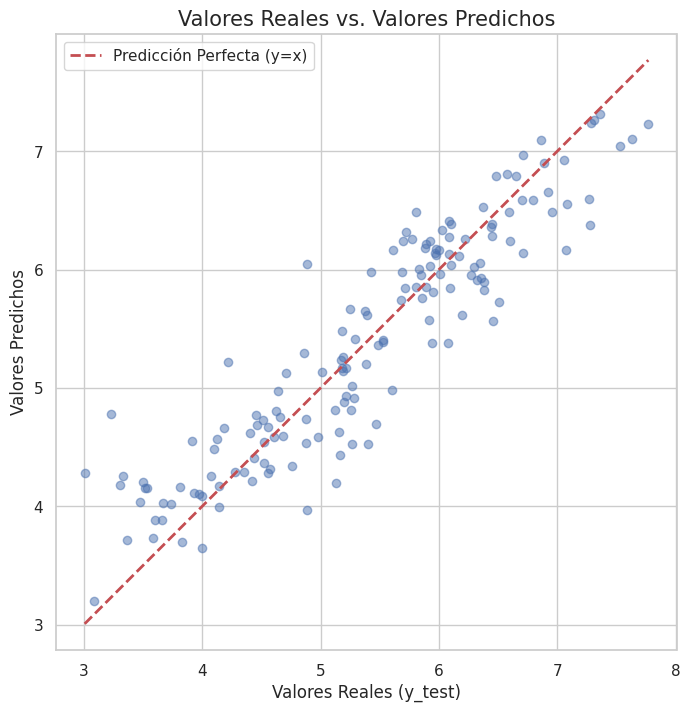

2025-05-20 02:40:49,534 - INFO - 1213935883.py:22 - Gráfico de valores predichos vs. reales generado.


In [963]:
# Celda 22: Gráfico de Valores Predichos vs. Valores Reales

if ('y_test' in locals() and y_test is not None and
    'y_pred_test_final' in locals() and y_pred_test_final is not None):

    logging.info("Generando gráfico de valores predichos vs. valores reales.")
    print("\n--- Gráfico de Predichos vs. Reales ---")

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_test_final, alpha=0.5)
    # Añadimos una línea y=x, que representa la predicción perfecta
    min_val = min(y_test.min(), y_pred_test_final.min())
    max_val = max(y_test.max(), y_pred_test_final.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta (y=x)')
    plt.title('Valores Reales vs. Valores Predichos', fontsize=15)
    plt.xlabel('Valores Reales (y_test)', fontsize=12)
    plt.ylabel('Valores Predichos', fontsize=12)
    plt.legend()
    plt.axis('equal') # Asegura que la escala sea la misma en ambos ejes para una mejor comparación visual de la línea y=x
    plt.grid(True)
    plt.show()
    logging.info("Gráfico de valores predichos vs. reales generado.")

else:
    logging.error("y_test o y_pred_test_final no están disponibles para el gráfico de comparación.")
    print("Error: No se puede generar el gráfico de predichos vs. reales.")

In [ ]:
# Celda 23: Guardar el Mejor Modelo Optimizado
if ('final_best_model_pipeline' in locals() and final_best_model_pipeline is not None and
    'best_model_config_name' in locals() and best_model_config_name != "No_Determinado" and best_model_config_name != "Mejor_Modelo_No_Identificado"):

    logging.info(f"Iniciando el guardado del mejor modelo pipeline: {best_model_config_name}")

    # --- 1. Definir la ruta y el nombre del archivo del modelo ---
    MODELS_DIR = "/home/nicolas/Escritorio/workshops ETL/workshop_3/models"
    
    # Crear el directorio si no existe
    try:
        os.makedirs(MODELS_DIR, exist_ok=True) # exist_ok=True evita un error si el directorio ya existe
        logging.info(f"Directorio de modelos '{MODELS_DIR}' asegurado/creado.")
    except Exception as e:
        logging.error(f"Error al crear el directorio de modelos '{MODELS_DIR}': {e}")
        # Podrías decidir no continuar si no se puede crear el directorio
        # Por ahora, el intento de guardar procederá y fallará si el directorio no es accesible.

    # Crear un nombre de archivo descriptivo.
    # Podrías incluir la fecha, versión, o métricas clave en el nombre si lo deseas.
    model_filename = f"{best_model_config_name.replace(' ', '_').replace('/', '_')}_pipeline.joblib"
    model_filepath = os.path.join(MODELS_DIR, model_filename)

    # --- 2. Guardar el pipeline del modelo ---
    try:
        joblib.dump(final_best_model_pipeline, model_filepath)
        logging.info(f"Mejor modelo pipeline guardado exitosamente en: {model_filepath}")
        print(f"\n--- Mejor Modelo Guardado ---")
        print(f"El pipeline del modelo '{best_model_config_name}' ha sido guardado en:")
        print(model_filepath)
        
        # Opcional: Guardar también información sobre el modelo
        # Podrías guardar 'optimized_results_df' o la fila específica del mejor modelo.
        best_model_info_path = os.path.join(MODELS_DIR, f"{best_model_config_name.replace(' ', '_').replace('/', '_')}_info.txt")
        if 'optimized_results_df' in locals() and not optimized_results_df.empty:
            best_config_row_for_info = optimized_results_df[optimized_results_df['Configuration'] == best_model_config_name]
            if not best_config_row_for_info.empty:
                with open(best_model_info_path, 'w') as f:
                    f.write(f"Información del Modelo: {best_model_config_name}\n")
                    f.write("Resultados de la Optimización y Evaluación en Test:\n")
                    f.write(best_config_row_for_info.to_string())
                logging.info(f"Información del mejor modelo guardada en: {best_model_info_path}")
            
    except Exception as e:
        logging.error(f"Error al guardar el modelo pipeline en '{model_filepath}': {e}")
        print(f"\nError al guardar el modelo: {e}")

else:
    logging.error("No se puede guardar el modelo: 'final_best_model_pipeline' no está disponible o no se identificó un mejor modelo.")
    print("\nError: El mejor modelo no está disponible para ser guardado.")

2025-05-20 02:57:40,131 - INFO - 2736759513.py:11 - Iniciando el guardado del mejor modelo pipeline: GradientBoosting_S1
2025-05-20 02:57:40,132 - INFO - 2736759513.py:19 - Directorio de modelos '/home/nicolas/Escritorio/workshops ETL/workshop_3/models' asegurado/creado.
2025-05-20 02:57:40,143 - INFO - 2736759513.py:33 - Mejor modelo pipeline guardado exitosamente en: /home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_pipeline.joblib
2025-05-20 02:57:40,148 - INFO - 2736759513.py:48 - Información del mejor modelo guardada en: /home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_info.txt



--- Mejor Modelo Guardado ---
El pipeline del modelo 'GradientBoosting_S1' ha sido guardado en:
/home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_pipeline.joblib
